# Attaque de schémas stéganographiques type "LSB".
La stéganographie est l'art de la dissimulation d'information dans de l'information. On retouve des traces de tels schémas dès l'antiquité. L'émergence de l'informatique a grandement participé au developpement de protocoles stéganographiques au cours du 20ème et 21ème siecles. La stéganographie a dès lors d'importantes applications en cybersécurité.

On s'interesse dans la suite à la dissimulation d'images dans d'autres images. Une manière courante d'effectuer ce genre de dissimulation est d'utiliser la méthode LSB (Least Significant Bit). En RGB chaque pixel est codé sur 24 bits : 8 bits par couleur et 3 couleurs (Rouge, Vert, Bleu). On dit que les 4 premiers bits de chaque couleur sont de poids fort (c'est eux qui vont principalement déterminer la couleur du pixel) et les 4 bits suivants sont dits de poids faible (moins importants pour le rendu de l'image). Imaginons que l'on veuille cacher une image B (Base) dans une image C (Couverture). La methode LSB consiste à remplacer les bits faibles de C par les bits forts de B pour former l'image D (Dissimulation, très proche de C). 

**Exemple:**

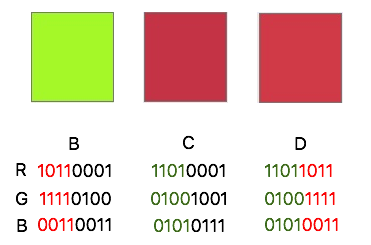

Ce schéma étant bien connu et massivement utilisé,  en faire usage ainsi pour échanger de l'information secrètement sur un réseau publique serait risqué. En effet, ce schéma rend peu soupçonnable une dissmimulation d'information, néanmoins si l'on a un soupçon. La méthode LSB donne parfois une impression d'inhomogénéité dans l'image publique (D) particulièrement lorsque qu'il y a  des plages de pixels d'une même couleur dans l'image de couverture comme un ciel ou une mer. Cela peut éveiller les soupçons d'un oeil averti. Il est naturel en premier lieu d'appliquer la méthode LSB inverse pour tenter de récupérer une éventuelle image cachée. On peut cependant appliquer plusieurs mesures pour rendre ce schéma plus sûr. Une méthode usuelle et efficace est de prétraiter l'image de base en permutant ses pixels, la permutation n'étant connue uniquement de ceux qui échangent secrètement. La permutation joue ainsi le rôle de clé de sécurité. Pour une image 100 par 100 (soit 10000 pixels) on a $10000!$ permutations possibles. Il est alors difficile de tester toutes les possibilités "à la main". Même si il y avait fuite d'information (récupération de quelques images secrètes) les attaques par "brut force" pour retrouver quelle permutation est utilisée sont alors peu envisageables (temps de calcul trop important).

**Exemple:**

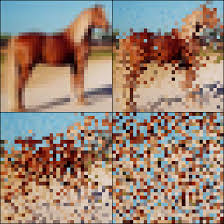

Dans la suite, on se place dans la situation suivante : Alice et Bob communiquent sur un réseau publique en échangeant des images dissimulées par une méthode type LSB. Une fuite d'information a lieu et un fichier contenant des images secrètes (base) est récupéré par une attaquante Eve. Elle possède aussi les dissimulations de ces images dans des images de couverture (accessibles à tous sur le canal publique). Eve qui ne sait pas exactement comment elles ont été dissimulées (ne connait pas la méthode utilisée). Elle cherche à déterminer la méthode exacte employée pour pouvoir récupérer les messages secrets à venir. Dans un premier temps, plus à titre "didactique", on s'intéresse au schéma "LSB simple" (sans prétraitement). La méthode LSB étant bien connue, cette approche peut paraître naïve, mais c'est un "cas jouet" intéressant et servira de référence pour la suite. Puis, au cas où il y a permutation sur l'image de Base (le "vrai" cas). On cherche ici à évaluer la robustesse de ces schémas face à des attaques utilisant des outils usuels de machine learning et deep learning.

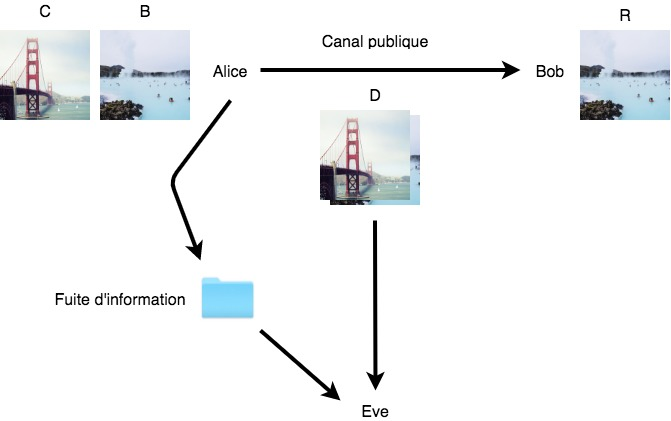

# Génération base de données

On construit un fichier 'Base' à partir d'images 10 par 10 (carrés de 100 pixels) récupérées via https://picsum.photos/10/10 qui génère aléatoirement des images (images issues de situations réelles, non simulées). Ce fichier nous permet de construire l'ensemble des images que l'on veut dissimuler et l'ensemble des images que l'on utilise comme couverture (il s'agit des mêmes ensembles). On dissimule chaque image de 'Base' dans toutes les autres pour construire un ensemble d'images dissimulées. On récupère par méthode "LSB" inverse les bits faibles des images dissimulées pour former l'ensemble des images récupérées. On a ainsi construit notre dataframe 100 par 4. Relancer le code tel quel générera un nouveau fichier 'Base' (et un nouveau fichier 'couverture2' pour la partie Modélisation 3). Les remarques faites sur les diagrammes et résultats des modèles ont été faites sur le jeu de données fourni (aussi généré par cette procédure). Il est donc préférable de passer la partie du code créant le fichier 'Base' (ou 'Couverture2' pour la partie Modélisation 3) et le remplissant d'images aléatoires pour importer directement les fichiers d'images 'Base' et 'Couverture2' fournis pour plus de cohérence (importer dans content sous Colab en .zip puis déziper ou en adaptant à votre environnement les directions path pour 'Base' et path2 pour 'Couverture 2' dans les cellules signalées). 

In [ ]:
from PIL import Image
import numpy as np
import pandas
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.mlab as mlab
from scipy.stats import norm

In [ ]:
##Conversion Decimale en Binaire de longeur d##
def binaire(d,n):
    if d==0:
        b="0"
    else:
        b=""
        while d!=0:
            b="01"[d&1]+b
            d=d>>1
    return b.zfill(n)



In [ ]:
##Passe les coefficient d'un array decimale (format depuis image RGB) en binaire##
def MatriceBin(M):
  Q=[]
  for L in M:
    P=[]
    for l in L:
      p=[]
      for x in l:
        p.append(binaire(x,8))
      P.append(p)
    Q.append(P)
  return(Q)



In [ ]:
##Passe les coefficient d'un array binaire(format depuis image RGB) en décimale##
def MatriceDec(M):
  Q=[]
  for L in M:
    P=[]
    for l in L:
      p=[]
      for x in l:
        p.append(int(x,2))
      P.append(p)
    Q.append(P)
  return(Q)



In [ ]:
##Dissimule un array dans un autre par la methode LSB##
def Dissimulation(M,A):
  N=MatriceBin(M)
  B=MatriceBin(A)
  Q=[]
  for i in range(len(N)):
    P=[]
    for j in range(len(N[0])):
      p=[]
      for k in range(len(N[0][0])):
        p.append(N[i][j][k][0:4]+B[i][j][k][0:4])
      P.append(p)
    Q.append(P)
  return(MatriceDec(Q))


In [ ]:
##Récupère un array caché dans un autre par methode LSB##
def Recuperation(C):
  B=MatriceBin(C)
  Q=[]
  for i in range(len(C)):
    P=[]
    for j in range(len(C[0])):
      p=[]
      for k in range(len(C[0][0])):
        p.append(B[i][j][k][4:9]+'0000')
      P.append(p)
    Q.append(P)
  return(MatriceDec(Q))

!////DEBUT ZONE DE CREATION DU FICHIER BASE////!


In [ ]:
##Créer un dossier Base dans /content (sous Colab, direction à changer si executer ailleurs)##
path = "/content/Base"
os.mkdir(path)

In [ ]:
##Génère une base d'image (libre de droit) et les stock dans le fichier Base##
for i in range(10):
  fullfilename = os.path.join(path, "photo" + str(i) + ".jpg")
  urllib.request.urlretrieve("https://picsum.photos/10/10", fullfilename)

In [ ]:
##télécharge Content##
!zip -r /content/file2.zip /content


!////FIN ZONE DE CREATION DU FICHIER BASE////!





Dans la cellule qui suit, on pourra adapter le chemin d'accès path au fichier 'Base' ("/content/Base") à son environnement d'éxecution. Si on utilise Colab, il faut importer le fichier .zip dans content puis le déziper avec la cellule suivante.

In [ ]:
!unzip Base.zip

In [ ]:
##Créer un dataframe avec ce qui précède##
path = "/content/Base"
L=[]
for files1 in os.listdir(path):
  for files2 in os.listdir(path):
    if files1!='.ipynb_checkpoints' and files2!='.ipynb_checkpoints':
      u1=path+'/'+files1
      u2=path+'/'+files2
      image1=mpimg.imread(u1)
      image2=mpimg.imread(u2)
      arrayB=np.array(image2)
      arrayC=np.array(image1)
      arrayD=np.array(Dissimulation(np.array(image1),np.array(image2)))
      arrayR=Recuperation(arrayD)
      L.append([arrayB,arrayC,arrayD,arrayR])
df = pandas.DataFrame(L, columns = ['Base', 'Couverture', 'Dissimulation', 'Récupération'])

In [ ]:
df

,Base,Couverture,Dissimulation,Récupération
0,"[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[221, 238, 238], [221, 238, 238], [221, 238,...","[[[208, 224, 224], [208, 224, 224], [208, 224,..."
1,"[[[129, 119, 109], [194, 181, 172], [223, 210,...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[216, 231, 230], [220, 235, 234], [221, 237,...","[[[128, 112, 96], [192, 176, 160], [208, 208, ..."
2,"[[[89, 130, 186], [78, 119, 175], [49, 90, 146...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[213, 232, 235], [212, 231, 234], [211, 229,...","[[[80, 128, 176], [64, 112, 160], [48, 80, 144..."
3,"[[[229, 234, 238], [243, 248, 252], [237, 242,...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[222, 238, 238], [223, 239, 239], [222, 239,...","[[[224, 224, 224], [240, 240, 240], [224, 240,..."
4,"[[[47, 94, 164], [50, 97, 167], [56, 100, 171]...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[210, 229, 234], [211, 230, 234], [211, 230,...","[[[32, 80, 160], [48, 96, 160], [48, 96, 160],..."
...,...,...,...,...
95,"[[[228, 228, 228], [240, 240, 240], [236, 236,...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[174, 94, 62], [159, 95, 47], [174, 110, 62]...","[[[224, 224, 224], [240, 240, 240], [224, 224,..."
96,"[[[124, 162, 171], [126, 163, 172], [131, 168,...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[167, 90, 58], [151, 90, 42], [168, 106, 59]...","[[[112, 160, 160], [112, 160, 160], [128, 160,..."
97,"[[[94, 94, 94], [135, 135, 135], [167, 167, 16...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[165, 85, 53], [152, 88, 40], [170, 106, 58]...","[[[80, 80, 80], [128, 128, 128], [160, 160, 16..."
98,"[[[206, 206, 206], [208, 208, 208], [209, 209,...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[172, 92, 60], [157, 93, 45], [173, 109, 61]...","[[[192, 192, 192], [208, 208, 208], [208, 208,..."


# Description de la base de données.

On cherche ici à décrire sommairement chaque colonne du dataframe précedent. On s'intéresse à la distribution des différents pixels dans chaque image contenue dans ces colonnes, ce qui nous permet d'avoir une meilleure compréhension quantitive et graphique (sur l'homogénéité de la distribution par exemple) et de faire quelques comparaisons entre ces colonnes. On précise ensuite ses comparaisons en introduistant des distances (image à image puis pixel à pixel). On compare aussi diférents spectres de quelques images pour finir de se convaincre du bien fondé de la méthode "LSB" (insoupçonnabilité et faible distortion des messages secrets).

Description de 'Base' (et donc 'Couverture' qui contient les mêmes images).

In [ ]:
##Creation d'une liste contenant l'ensemble des intensités  (relative a une R, G ou B) des pixels d'une liste d'images.##
def PixelList(A,n):
  L=[]
  for x in A:
    for i in range(len(x)):
       for j in range(len(x)):
          L.append(x[i][j][n])
  return(L)

Text(0.5, 1.0, "Occurence des intensité sur les rouges dans 'Base'")

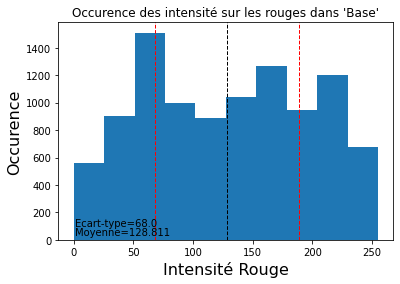

In [ ]:
plt.hist(PixelList(df['Base'],0))
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Base'],0)), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Base'],0),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Base'],0),0.75), color='r', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Base'],0))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Base'],0)))))
plt.title("Occurence des intensité sur les rouges dans 'Base'")

On remarque que la distribution sur les rouges de l'ensemble des pixels des images contenues dans base n'est pas complètement uniforme. Ce qui s'explique premièrement par le fait qu'il n'y ait que dix images différentes dans 'Base' et qu'elles sont de petite dimension . Mais aussi peut-être car ces images proviennent de situations réelles (on ne tire pas au hasard la couleur de chaque pixel, il s'agit de portraits, de paysages,...) et donc peut-être qu'il n'est pas équiprobable d'observer dans la nature chaque intensité de rouge.

Text(0.5, 1.0, "Occurence des intensité sur les verts dans 'Base'")

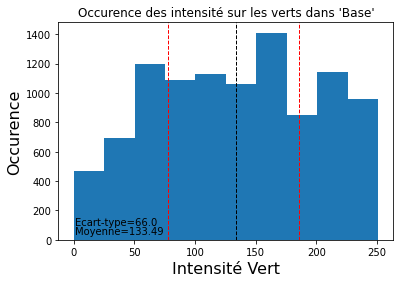

In [ ]:
plt.hist(PixelList(df['Base'],1))
plt.xlabel("Intensité Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Base'],1)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Base'],1))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Base'],1)))))
plt.axvline(np.quantile(PixelList(df['Base'],1),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Base'],1),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les verts dans 'Base'")

Idem ici pas d'uniformité. Mêmes raisons que précèdemment.

Text(0.5, 1.0, "Occurence des intensité sur les bleus dans 'Base'")

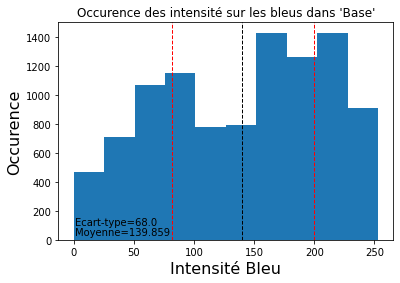

In [ ]:
plt.hist(PixelList(df['Base'],2))
plt.xlabel("Intensité Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Base'],2)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Base'],2))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Base'],2)))))
plt.axvline(np.quantile(PixelList(df['Base'],2),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Base'],2),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les bleus dans 'Base'")

Idem ici pas d'uniformité. Mêmes raisons que précèdemment.

In [ ]:
def sumColorInt(A):
  L=[]
  for k in range(len(A)):
    SR=0
    SV=0
    SB=0
    for i in range(len(A[0][0])):
        for j in range(len(A[0][0])):
            SR=SR+A[k][i][j][0]
            SV=SV+A[k][i][j][1]
            SB=SB+A[k][i][j][2]
    L.append([SR,SV,SB])
  return(L)
np.array(sumColorInt(df['Base'])[0:10]).T

array([[17628, 16571,  7470, 12123,  7095, 19817, 14215,  7430, 12654,
        13808],
       [18428, 15724,  9937, 13793, 11088, 19817, 14247,  7430, 12654,
        10372],
       [18728, 15355, 13567, 14793, 15551, 19817, 13942,  7430, 12654,
         8022]])

Text(0.5, 1.0, "Intensité cumulé selon R, G, B des images dans 'Base'")

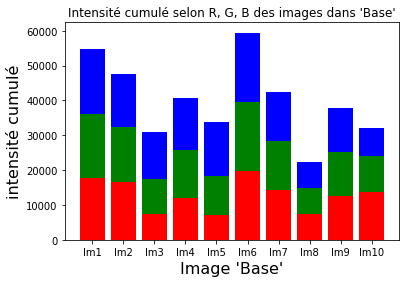

In [ ]:
Yc=np.array(sumColorInt(df['Base'])[0:10]).T
Xc=['Im1','Im2','Im3','Im4','Im5','Im6','Im7','Im8','Im9','Im10']

plt.bar(Xc , Yc[0], color = 'r')
plt.bar(Xc, Yc[1],bottom=Yc[0], color = 'g')
plt.bar(Xc, Yc[2],bottom=Yc[1]+Yc[0], color = 'b')
plt.xlabel("Image 'Base'", fontsize=16)  
plt.ylabel("intensité cumulé", fontsize=16)
plt.title("Intensité cumulé selon R, G, B des images dans 'Base'")

On remarque ici que les parts de 'rouge', de 'bleu' et de 'vert' sont plus ou moins égales sur chaque image.

Text(0.5, 1.0, "Distribution des couples R/V dans 'Base'")

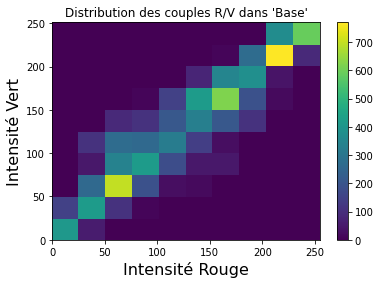

In [ ]:
plt.hist2d(PixelList(df['Base'],0),PixelList(df['Base'],1))
plt.colorbar()
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Intensité Vert", fontsize=16)
plt.title("Distribution des couples R/V dans 'Base'")

Ici on voit que l'on n'a pas une distribution uniforme des couples d'intensités (Vert,Rouge), se concentrant autour de la première bisectrice.

Text(0.5, 1.0, "Distribution des couples R/B dans 'Base'")

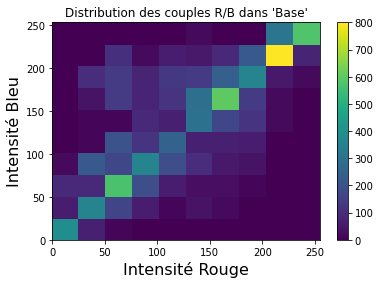

In [ ]:
plt.hist2d(PixelList(df['Base'],0),PixelList(df['Base'],2))
plt.colorbar()
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Intensité Bleu", fontsize=16)
plt.title("Distribution des couples R/B dans 'Base'")

On fait ici un constat similaire, pas d'uniformité. concentration autour de la première bisectrice.

Text(0.5, 1.0, "Distribution des couples V/B dans 'Base'")

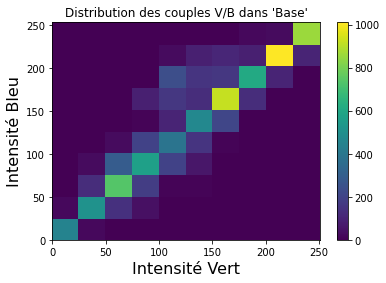

In [ ]:
plt.hist2d(PixelList(df['Base'],1),PixelList(df['Base'],2))
plt.colorbar()
plt.xlabel("Intensité Vert", fontsize=16)  
plt.ylabel("Intensité Bleu", fontsize=16)
plt.title("Distribution des couples V/B dans 'Base'")

Idem ici. Ces 3 graphes nous montrent que les valeurs des intensités R,G,B sont souvent proches dans les images de 'Base'. On a donc souvent des couleurs proches du "gris" ce qui est cohérent avec ce que l'on peut constater en regardant les images du fichier. C'est aussi cohérent avec les graphes précédents.

Description de 'Dissimulation'.

Text(0.5, 1.0, "Occurence des intensité sur les rouges dans 'Dissimulation'")

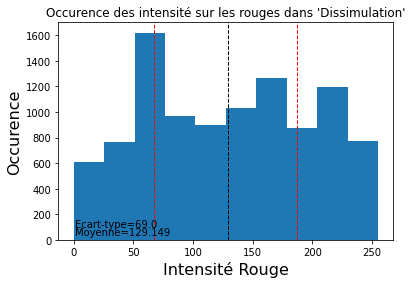

In [ ]:
plt.hist(PixelList(df['Dissimulation'],0))
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Dissimulation'],0)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Dissimulation'],0))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Dissimulation'],0)))))
plt.axvline(np.quantile(PixelList(df['Dissimulation'],0),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Dissimulation'],0),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les rouges dans 'Dissimulation'")

Text(0.5, 1.0, "Occurence des intensité sur les verts dans 'Dissimulation'")

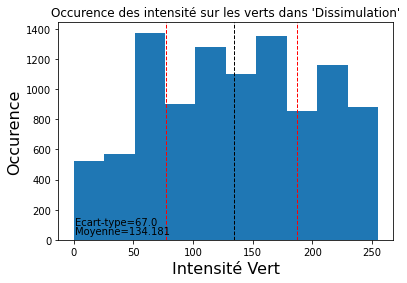

In [ ]:
plt.hist(PixelList(df['Dissimulation'],1))
plt.xlabel("Intensité Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Dissimulation'],1)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Dissimulation'],1))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Dissimulation'],1)))))
plt.axvline(np.quantile(PixelList(df['Dissimulation'],1),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Dissimulation'],1),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les verts dans 'Dissimulation'")

Text(0.5, 1.0, "Occurence des intensité sur les bleus dans 'Dissimulation'")

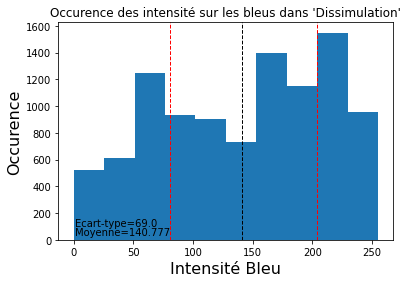

In [ ]:
plt.hist(PixelList(df['Dissimulation'],2))
plt.xlabel("Intensité Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Dissimulation'],2)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Dissimulation'],2))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Dissimulation'],2)))))
plt.axvline(np.quantile(PixelList(df['Dissimulation'],2),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Dissimulation'],2),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les bleus dans 'Dissimulation'")

Les trois graphes précédents sont trés similaires à ceux obtenus lors de la description des images de 'Base' qui sont aussi celles de 'Couverture'. Le procédé de Dissimulation "LSB" semble donc peu modifier la distribution des intensités de chaque couleur des images de couverture.

In [ ]:
sumColorInt(df['Dissimulation'])

[[17901, 18802, 19142],
 [17832, 18634, 18926],
 [17270, 18272, 18820],
 [17563, 18512, 18891],
 [17248, 18339, 18938],
 [18043, 18891, 19211],
 [17692, 18543, 18841],
 [17267, 18115, 18435],
 [17599, 18447, 18767],
 [17662, 18298, 18470],
 [16797, 16114, 15686],
 [16728, 15946, 15470],
 [16166, 15584, 15364],
 [16459, 15824, 15435],
 [16144, 15651, 15482],
 [16939, 16203, 15755],
 [16588, 15855, 15385],
 [16163, 15427, 14979],
 [16495, 15759, 15311],
 [16558, 15610, 15014],
 [7805, 10322, 13990],
 [7736, 10154, 13774],
 [7174, 9792, 13668],
 [7467, 10032, 13739],
 [7152, 9859, 13786],
 [7947, 10411, 14059],
 [7596, 10063, 13689],
 [7171, 9635, 13283],
 [7503, 9967, 13615],
 [7566, 9818, 13318],
 [12493, 14162, 15126],
 [12424, 13994, 14910],
 [11862, 13632, 14804],
 [12155, 13872, 14875],
 [11840, 13699, 14922],
 [12635, 14251, 15195],
 [12284, 13903, 14825],
 [11859, 13475, 14419],
 [12191, 13807, 14751],
 [12254, 13658, 14454],
 [7453, 11394, 15878],
 [7384, 11226, 15662],
 [6822, 1

Text(0.5, 1.0, "Intensité cumulé selon R, G, B des images dans 'Dissimulation'")

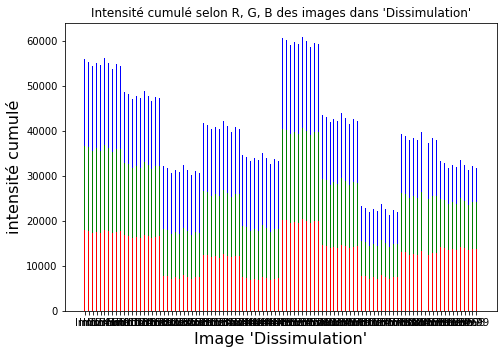

In [ ]:
Yc=np.array(sumColorInt(df['Dissimulation'])).T
Xc=['Im'+str(i) for i in range(100)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Xc , Yc[0], color = 'r', width = 0.25)
ax.bar(Xc, Yc[1], bottom=Yc[0], color = 'g', width = 0.25)
ax.bar(Xc, Yc[2], bottom=Yc[1]+Yc[0],color = 'b', width = 0.25)
plt.xlabel("Image 'Dissimulation'", fontsize=16)  
plt.ylabel("intensité cumulée", fontsize=16)
plt.title("Intensité cumulée selon R, G, B des images dans 'Dissimulation'")

On remarque ici qu'il y a peu de différence entre ces résultats et les résultats obtenus sur 'Base' qui sont aussi ceux de 'Couverture'.  La Dissimulation par méthode "LSB" préserve l'intensité cumulée de chaque couleur et la répartition entre les trois couleurs dans l'intensité cumulée totale des images de Couvertures. La figure montre aussi que le choix de l'image dissimulée fait peu varier ces quantités.

Text(0.5, 1.0, "Distribution des couples R/V dans 'Dissimulation'")

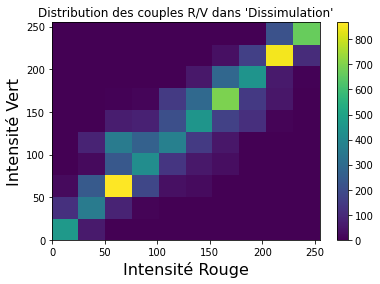

In [ ]:
plt.hist2d(PixelList(df['Dissimulation'],0),PixelList(df['Dissimulation'],1))
plt.colorbar()
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Intensité Vert", fontsize=16)
plt.title("Distribution des couples R/V dans 'Dissimulation'")

Text(0.5, 1.0, "Distribution des couples R/B dans 'Dissimulation'")

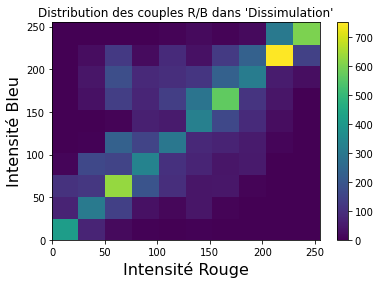

In [ ]:
plt.hist2d(PixelList(df['Dissimulation'],0),PixelList(df['Dissimulation'],2))
plt.colorbar()
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Intensité Bleu", fontsize=16)
plt.title("Distribution des couples R/B dans 'Dissimulation'")

Text(0.5, 1.0, "Distribution des couples V/B dans 'Dissimulation'")

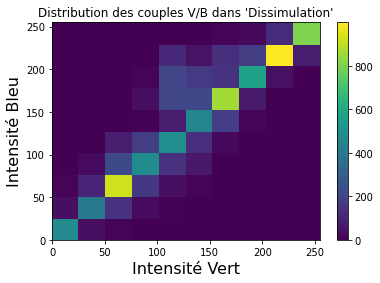

In [ ]:
plt.hist2d(PixelList(df['Dissimulation'],1),PixelList(df['Dissimulation'],2))
plt.colorbar()
plt.xlabel("Intensité Vert", fontsize=16)  
plt.ylabel("Intensité Bleu", fontsize=16)
plt.title("Distribution des couples V/B dans 'Dissimulation'")

Même conclusion que précèdement. Peu de modification sur l'image de couverture.

Description de 'Récupération'.

Text(0.5, 1.0, "Occurence des intensité sur les rouges dans 'Récupération'")

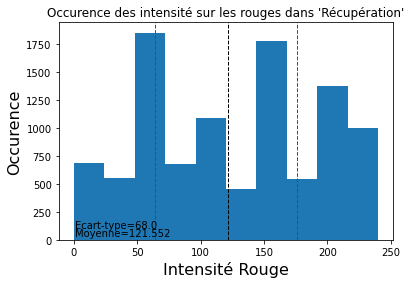

In [ ]:
plt.hist(PixelList(df['Récupération'],0))
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Récupération'],0)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Récupération'],0))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Récupération'],0)))))
plt.axvline(np.quantile(PixelList(df['Récupération'],0),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Récupération'],0),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les rouges dans 'Récupération'")

On remarque comme pour la dissimulation (même si ici l'écrasement dû à un ymax plus important le rend moins flagrant visuellement), la distribution sur les rouges des images récupérées est proche de celle des images de base. 

Text(0.5, 1.0, "Occurence des intensité sur les verts dans 'Récupération'")

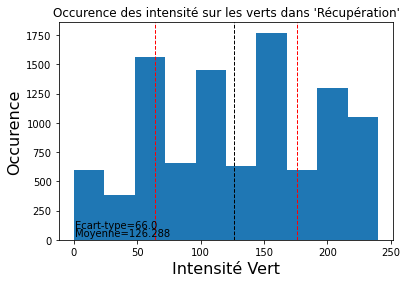

In [ ]:
plt.hist(PixelList(df['Récupération'],1))
plt.xlabel("Intensité Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Récupération'],1)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Récupération'],1))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Récupération'],1)))))
plt.axvline(np.quantile(PixelList(df['Récupération'],1),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Récupération'],1),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les verts dans 'Récupération'")

Idem pour les verts.

Text(0.5, 1.0, "Occurence des intensité sur les bleus dans 'Récupération'")

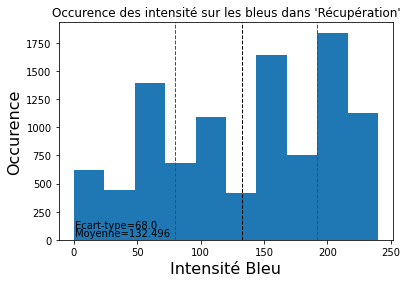

In [ ]:
plt.hist(PixelList(df['Récupération'],2))
plt.xlabel("Intensité Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(PixelList(df['Récupération'],2)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,35,'Moyenne='+str(np.mean(PixelList(df['Récupération'],2))))
plt.text(1,100,'Ecart-type='+str(round(np.std(PixelList(df['Récupération'],2)))))
plt.axvline(np.quantile(PixelList(df['Récupération'],2),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(PixelList(df['Récupération'],2),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence des intensité sur les bleus dans 'Récupération'")

Idem pour les bleus. La méthode "LSB" détériore donc peu la distribution de l'intensité des couleurs.

Text(0.5, 1.0, "Intensité cumulé selon R, G, B des images dans 'Récupération'")

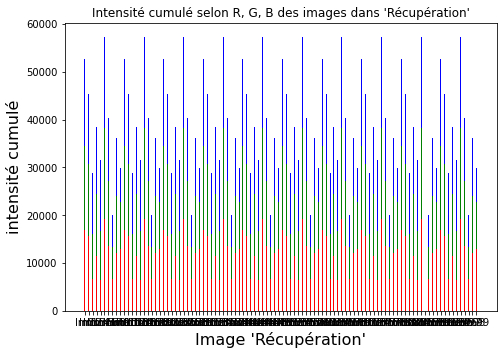

In [ ]:
Yc=np.array(sumColorInt(df['Récupération'])).T
Xc=['Im'+str(i) for i in range(100)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Xc , Yc[0], color = 'r', width = 0.25)
ax.bar(Xc, Yc[1], bottom=Yc[0], color = 'g', width = 0.25)
ax.bar(Xc, Yc[2], bottom=Yc[1]+Yc[0] ,color = 'b', width = 0.25)
plt.xlabel("Image 'Récupération'", fontsize=16)  
plt.ylabel("intensité cumulée", fontsize=16)
plt.title("Intensité cumulée selon R, G, B des images dans 'Récupération'")

Ici on remarque que la méthode "LSB" préserve l'intensité cumulée de chaque couleur et la répartition entre les trois couleurs dans l'intensité cumulée totale des images récupérées. On remarque aussi que le choix de l'image de couverture n'influe pas sur cette distribution (évident puisque pour une image de base donnée quelque soit l'image de couverture les bits faibles de l'image de dissimulation sont identiques).

Text(0.5, 1.0, "Distribution des couples R/V dans 'Récupération'")

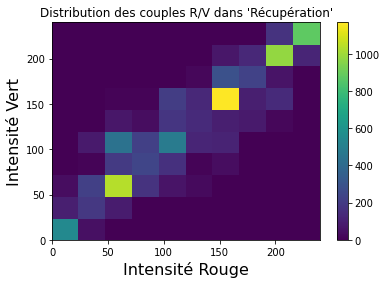

In [ ]:
plt.hist2d(PixelList(df['Récupération'],0),PixelList(df['Récupération'],1))
plt.colorbar()
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Intensité Vert", fontsize=16)
plt.title("Distribution des couples R/V dans 'Récupération'")

Text(0.5, 1.0, "Distribution des couples R/B dans 'Récupération'")

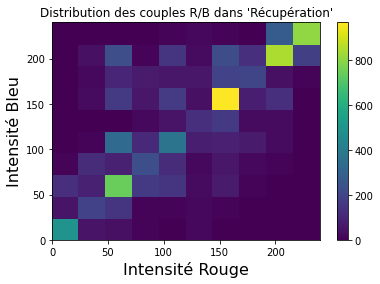

In [ ]:
plt.hist2d(PixelList(df['Récupération'],0),PixelList(df['Récupération'],2))
plt.colorbar()
plt.xlabel("Intensité Rouge", fontsize=16)  
plt.ylabel("Intensité Bleu", fontsize=16)
plt.title("Distribution des couples R/B dans 'Récupération'")

Text(0.5, 1.0, "Distribution des couples V/B dans 'Récupération'")

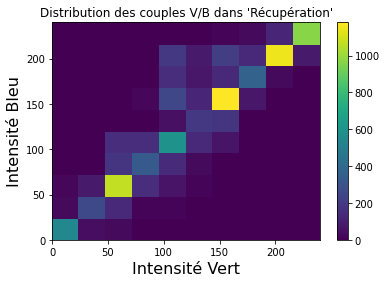

In [ ]:
plt.hist2d(PixelList(df['Récupération'],1),PixelList(df['Récupération'],2))
plt.colorbar()
plt.xlabel("Intensité Vert", fontsize=16)  
plt.ylabel("Intensité Bleu", fontsize=16)
plt.title("Distribution des couples V/B dans 'Récupération'")

Les trois graphes précédents sont trés proches des graphes observés pour les images de bases et donc continuent à confirmer qu'on perd peu d'information avec la méthode LSB.

Comparaison de 'Base' et 'Récupération'.

In [ ]:
##Calcul la distance entre deux images##
def distanceImage(M,N):
  S=0
  for i in range(len(N)):
    for j in range(len(N[0])):
      for k in range(len(N[0][0])):
        S=S+abs(M[i][j][k]-N[i][j][k])
  return(S)

In [ ]:
## Calcul la distance entre Base et récupération##
D=[]
for i in range(len(df['Base'])):
  S=distanceImage(df['Base'][i],df['Récupération'][i])
  D.append(S)
print(D)

[2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282, 2224, 2338, 2142, 2213, 2294, 2091, 2148, 2178, 1914, 2282]


Text(0.5, 1.0, "Occurence distance image à image entre 'Base' et 'Récupration' ")

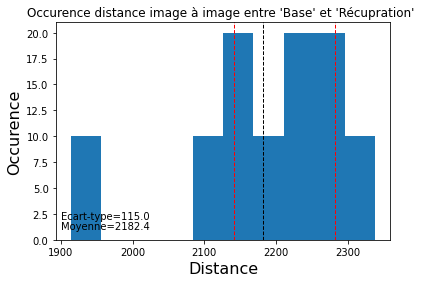

In [ ]:
plt.hist(D)
plt.xlabel("Distance", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(D), color='k', linestyle='dashed', linewidth=1)
plt.text(1900,2,'Ecart-type='+str(round(np.std(D))))
plt.text(1900,1,'Moyenne='+str(np.mean(D)))
plt.axvline(np.quantile(D,0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(D,0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance image à image entre 'Base' et 'Récupration' ")

In [ ]:
##Calcul la distance pixel à pixel entre deux image##
def distanceImagePixel(M,N):
  D=[]
  S=0
  for i in range(len(N)):
    for j in range(len(N[0])):
      S=S+abs(M[i][j][0]-N[i][j][0])+abs(M[i][j][1]-N[i][j][1])+abs(M[i][j][2]-N[i][j][2])
      D.append(S)
      S=0
  return(D)
print(distanceImagePixel(df['Base'][1],df['Récupération'][1]))

[21, 19, 26, 29, 15, 36, 15, 20, 28, 17, 23, 19, 25, 20, 35, 27, 26, 25, 31, 31, 27, 32, 23, 21, 25, 33, 16, 24, 19, 17, 36, 31, 21, 25, 34, 16, 22, 24, 24, 29, 15, 19, 25, 23, 23, 22, 27, 29, 34, 37, 17, 21, 21, 20, 21, 17, 24, 14, 21, 22, 9, 6, 36, 21, 29, 6, 23, 21, 33, 12, 9, 27, 24, 42, 21, 30, 42, 21, 36, 18, 15, 30, 9, 33, 18, 15, 42, 6, 17, 25, 39, 3, 39, 24, 15, 12, 18, 19, 31, 23]


In [ ]:
## Calcul la distance pixel à pixel entre Base et récupération##
d=[]
for i in range(len(df['Base'])):
  S=distanceImagePixel(df['Base'][i],df['Récupération'][i])
  d.append(S)
print(d)

[[17, 23, 29, 19, 19, 29, 23, 17, 20, 17, 26, 20, 11, 21, 31, 18, 21, 24, 24, 21, 18, 31, 25, 19, 32, 32, 19, 19, 21, 24, 14, 26, 25, 21, 21, 31, 22, 29, 29, 32, 22, 31, 11, 23, 29, 23, 17, 11, 14, 17, 26, 23, 14, 11, 11, 17, 26, 32, 24, 11, 23, 14, 18, 28, 31, 24, 23, 32, 19, 32, 19, 22, 25, 31, 24, 14, 20, 23, 20, 14, 19, 18, 26, 21, 26, 28, 18, 23, 22, 32, 26, 25, 17, 22, 14, 29, 19, 24, 18, 28], [21, 19, 26, 29, 15, 36, 15, 20, 28, 17, 23, 19, 25, 20, 35, 27, 26, 25, 31, 31, 27, 32, 23, 21, 25, 33, 16, 24, 19, 17, 36, 31, 21, 25, 34, 16, 22, 24, 24, 29, 15, 19, 25, 23, 23, 22, 27, 29, 34, 37, 17, 21, 21, 20, 21, 17, 24, 14, 21, 22, 9, 6, 36, 21, 29, 6, 23, 21, 33, 12, 9, 27, 24, 42, 21, 30, 42, 21, 36, 18, 15, 30, 9, 33, 18, 15, 42, 6, 17, 25, 39, 3, 39, 24, 15, 12, 18, 19, 31, 23], [21, 36, 13, 18, 20, 28, 19, 19, 19, 33, 17, 24, 18, 23, 26, 27, 18, 28, 1, 22, 17, 20, 15, 20, 9, 8, 24, 32, 26, 15, 17, 22, 25, 15, 25, 18, 15, 23, 17, 21, 22, 36, 33, 24, 18, 13, 9, 18, 31, 21, 12, 2

Text(0.5, 1.0, "Occurence distance pixel à pixel entre 'Base' et 'Récupration' ")

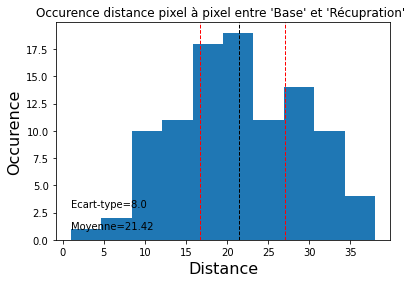

In [ ]:
plt.hist(distanceImagePixel(df['Base'][2],df['Récupération'][2]))
plt.xlabel("Distance", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixel(df['Base'][2],df['Récupération'][2])), color='k', linestyle='dashed', linewidth=1)
plt.text(1,3,'Ecart-type='+str(round(np.std(distanceImagePixel(df['Base'][2],df['Récupération'][2])))))
plt.text(1,1,'Moyenne='+str(np.mean(distanceImagePixel(df['Base'][2],df['Récupération'][2]))))
plt.axvline(np.quantile(distanceImagePixel(df['Base'][2],df['Récupération'][2]),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixel(df['Base'][2],df['Récupération'][2]),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel entre 'Base' et 'Récupration' ")

In [ ]:
##Calcul la distance sur chaque couleur (R,G,B) pixel à pixel entre deux image##
def distanceImagePixelC(M,N,n):
  D=[]
  S=0
  for i in range(len(N)):
    for j in range(len(N[0])):
      S=S+abs(M[i][j][n]-N[i][j][n])
      D.append(S)
      S=0
  return(D)
print(distanceImagePixelC(df['Base'][1],df['Récupération'][1],0))

[1, 2, 15, 6, 3, 15, 1, 9, 14, 6, 7, 11, 4, 3, 15, 8, 3, 15, 9, 15, 8, 15, 12, 13, 10, 14, 4, 13, 13, 13, 15, 8, 10, 7, 10, 0, 3, 0, 6, 13, 1, 13, 15, 10, 10, 15, 7, 13, 11, 12, 5, 1, 1, 6, 1, 12, 9, 11, 8, 3, 6, 5, 15, 10, 2, 5, 0, 10, 14, 7, 4, 10, 9, 15, 8, 10, 14, 7, 12, 5, 5, 10, 3, 11, 6, 4, 13, 1, 14, 6, 13, 1, 13, 7, 4, 3, 5, 4, 8, 15]


Text(0.5, 1.0, "Occurence distance pixel à pixel entre 'Base' et 'Récupration' sur les rouges")

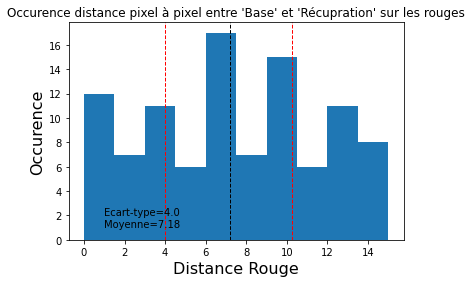

In [ ]:
plt.hist(distanceImagePixelC(df['Base'][2],df['Récupération'][2],0))
plt.xlabel("Distance Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixelC(df['Base'][2],df['Récupération'][2],0)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,2,'Ecart-type='+str(round(np.std(distanceImagePixelC(df['Base'][2],df['Récupération'][2],0)))))
plt.text(1,1,'Moyenne='+str(np.mean(distanceImagePixelC(df['Base'][2],df['Récupération'][2],0))))
plt.axvline(np.quantile(distanceImagePixelC(df['Base'][2],df['Récupération'][2],0),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixelC(df['Base'][2],df['Récupération'][2],0),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel entre 'Base' et 'Récupration' sur les rouges")

Text(0.5, 1.0, "Occurence distance pixel à pixel entre 'Base' et 'Récupration' sur les verts")

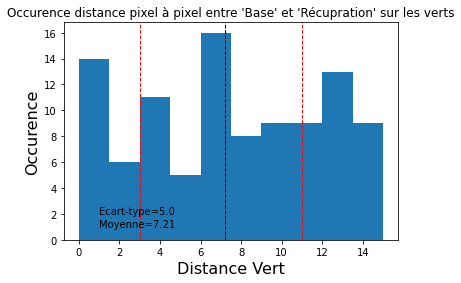

In [ ]:
plt.hist(distanceImagePixelC(df['Base'][2],df['Récupération'][2],1))
plt.xlabel("Distance Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.text(1,2,'Ecart-type='+str(round(np.std(distanceImagePixelC(df['Base'][2],df['Récupération'][2],1)))))
plt.axvline(np.mean(distanceImagePixelC(df['Base'][2],df['Récupération'][2],1)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,1,'Moyenne='+str(np.mean(distanceImagePixelC(df['Base'][2],df['Récupération'][2],1))))
plt.axvline(np.quantile(distanceImagePixelC(df['Base'][2],df['Récupération'][2],1),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixelC(df['Base'][2],df['Récupération'][2],1),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel entre 'Base' et 'Récupration' sur les verts")

Text(0.5, 1.0, "Occurence distance pixel à pixel entre 'Base' et 'Récupration' sur les bleus")

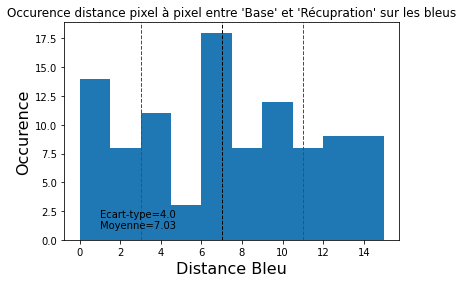

In [ ]:
plt.hist(distanceImagePixelC(df['Base'][2],df['Récupération'][2],2))
plt.xlabel("Distance Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixelC(df['Base'][2],df['Récupération'][2],2)), color='k', linestyle='dashed', linewidth=1)
plt.text(1,2,'Ecart-type='+str(round(np.std(distanceImagePixelC(df['Base'][2],df['Récupération'][2],2)))))
plt.text(1,1,'Moyenne='+str(np.mean(distanceImagePixelC(df['Base'][2],df['Récupération'][2],2))))
plt.axvline(np.quantile(distanceImagePixelC(df['Base'][2],df['Récupération'][2],2),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixelC(df['Base'][2],df['Récupération'][2],2),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel entre 'Base' et 'Récupration' sur les bleus")

In [ ]:
##Renvoie "le spectre" des rouges d'une image##
def SpectrePixelR(M):
  D=[]
  for i in range(len(M)):
    for j in range(len(M[0])):
      D.append(M[i][j][0])
  return(D)

Text(0.5, 1.0, "Exemple comparatif de spectres des rouges entre 'Base' et 'Récuperation'")

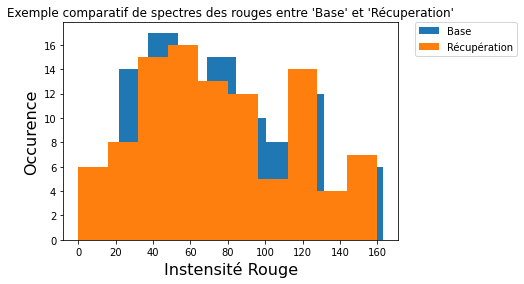

In [ ]:
##Compare graphiquement le spectre des rouges d'une image de base et sa version recupéré##
plt.hist(SpectrePixelR(df['Base'][2]),label="Base")
plt.hist(SpectrePixelR(df['Récupération'][2]),label="Récupération")
plt.xlabel("Instensité Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Exemple comparatif de spectres des rouges entre 'Base' et 'Récuperation'")

On observe ici un léger décalage du spectre entre Base et Récupération mais les deux graphes ont dans l'ensemble la même allure. 

Text(0.5, 1.0, "Exemple comparatif de spectres des verts entre 'Base' et 'Récuperation'")

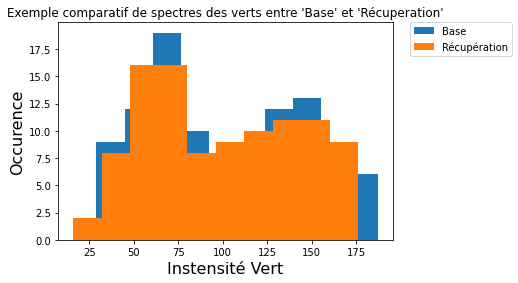

In [ ]:
##idem pour les verts##
def SpectrePixelV(M):
  D=[]
  for i in range(len(M)):
    for j in range(len(M[1])):
      D.append(M[i][j][1])
  return(D)
plt.hist(SpectrePixelV(df['Base'][2]),label="Base")
plt.hist(SpectrePixelV(df['Récupération'][2]),label="Récupération")
plt.xlabel("Instensité Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Exemple comparatif de spectres des verts entre 'Base' et 'Récuperation'")

Idem ici. Léger décalage du spectre.

Text(0.5, 1.0, "Exemple comparatif de spectres des bleus entre 'Base' et 'Récuperation'")

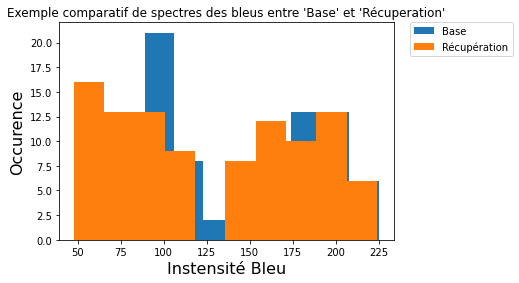

In [ ]:
##idem pour les bleus##
def SpectrePixelB(M):
  D=[]
  for i in range(len(M)):
    for j in range(len(M[1])):
      D.append(M[i][j][2])
  return(D)
plt.hist(SpectrePixelB(df['Base'][2]),label="Base")
plt.hist(SpectrePixelB(df['Récupération'][2]),label="Récupération")
plt.xlabel("Instensité Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Exemple comparatif de spectres des bleus entre 'Base' et 'Récuperation'")

Idem ici. Léger décalage du spectre. Ceci nous permet de constater à nouveau que la méthode LSB déforme donc peu l'image initiale.

Comparaison de 'Couverture' et 'Dissimulation'.

Text(0.5, 1.0, "Occurence distance image à image entre 'Dissimulation' et 'Couverture' ")

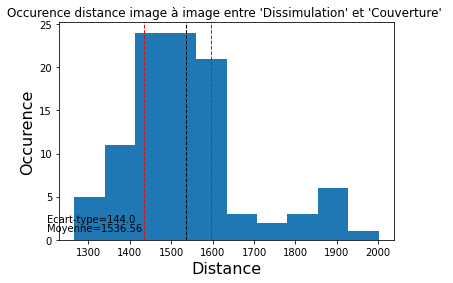

In [ ]:
## Calcul la distance entre Couverture et Dissimulation##
D2=[]
for i in range(len(df['Couverture'])):
  S=distanceImage(df['Couverture'][i],df['Dissimulation'][i])
  D2.append(S)

plt.hist(D2)
plt.xlabel("Distance", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(D2), color='k', linestyle='dashed', linewidth=1)
plt.text(1200,2,'Ecart-type='+str(round(np.std(D2))))
plt.text(1200,1,'Moyenne='+str(np.mean(D2)))
plt.axvline(np.quantile(D2,0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(D2,0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance image à image entre 'Dissimulation' et 'Couverture' ")

Text(0.5, 1.0, "Occurence distance pixel à pixel entre 'Dissimulation' et 'Couverture' ")

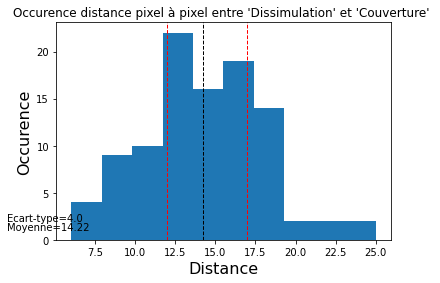

In [ ]:
plt.hist(distanceImagePixel(df['Couverture'][2],df['Dissimulation'][2]))
plt.xlabel("Distance", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixel(df['Couverture'][2],df['Dissimulation'][2])), color='k', linestyle='dashed', linewidth=1)
plt.text(2,2,'Ecart-type='+str(round(np.std(distanceImagePixel(df['Couverture'][2],df['Dissimulation'][2])))))
plt.text(2,1,'Moyenne='+str(np.mean(distanceImagePixel(df['Couverture'][2],df['Dissimulation'][2]))))
plt.axvline(np.quantile(distanceImagePixel(df['Couverture'][2],df['Dissimulation'][2]),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixel(df['Couverture'][2],df['Dissimulation'][2]),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel entre 'Dissimulation' et 'Couverture' ")

Text(0.5, 1.0, "Occurence distance pixel à pixel sur les rouges entre 'Dissimulation' et 'Couverture' ")

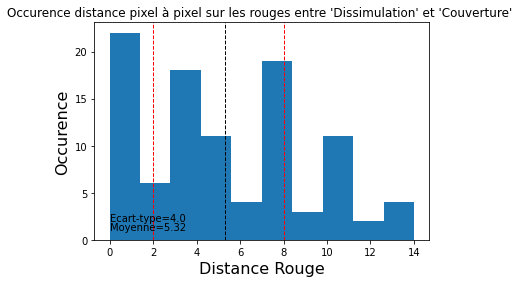

In [ ]:
plt.hist(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],0))
plt.xlabel("Distance Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],0)), color='k', linestyle='dashed', linewidth=1)
plt.text(0,2,'Ecart-type='+str(round(np.std(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],0)))))
plt.text(0,1,'Moyenne='+str(np.mean(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],0))))
plt.axvline(np.quantile(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],0),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],0),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel sur les rouges entre 'Dissimulation' et 'Couverture' ")

Text(0.5, 1.0, "Occurence distance pixel à pixel sur les verts entre 'Dissimulation' et 'Couverture' ")

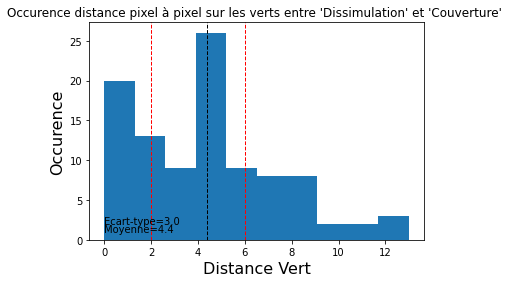

In [ ]:
plt.hist(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],1))
plt.xlabel("Distance Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],1)), color='k', linestyle='dashed', linewidth=1)
plt.text(0,2,'Ecart-type='+str(round(np.std(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],1)))))
plt.text(0,1,'Moyenne='+str(np.mean(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],1))))
plt.axvline(np.quantile(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],1),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],1),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel sur les verts entre 'Dissimulation' et 'Couverture' ")

Text(0.5, 1.0, "Occurence distance pixel à pixel sur les bleus entre 'Dissimulation' et 'Couverture' ")

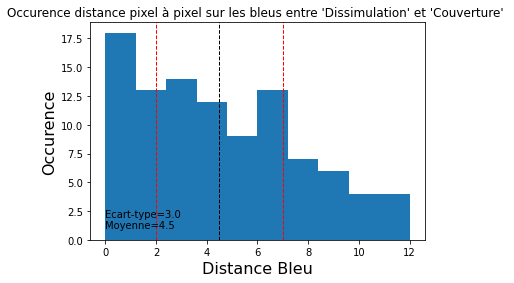

In [ ]:
plt.hist(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],2))
plt.xlabel("Distance Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.axvline(np.mean(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],2)), color='k', linestyle='dashed', linewidth=1)
plt.text(0,2,'Ecart-type='+str(round(np.std(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],2)))))
plt.text(0,1,'Moyenne='+str(np.mean(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],2))))
plt.axvline(np.quantile(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],2),0.25), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.quantile(distanceImagePixelC(df['Couverture'][2],df['Dissimulation'][2],2),0.75), color='r', linestyle='dashed', linewidth=1)
plt.title("Occurence distance pixel à pixel sur les bleus entre 'Dissimulation' et 'Couverture' ")

Text(0.5, 1.0, "Exemple comparatif de spectres des rouges entre 'Couverture' et 'Dissimulation'")

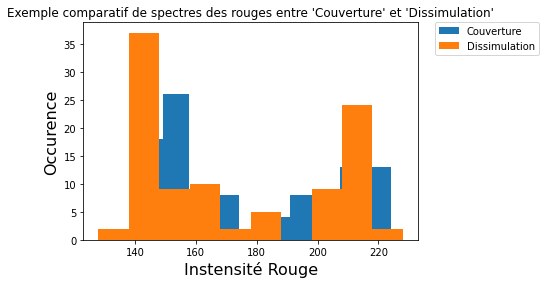

In [ ]:
plt.hist(SpectrePixelR(df['Couverture'][2]),label="Couverture")
plt.hist(SpectrePixelR(df['Dissimulation'][2]),label="Dissimulation")
plt.xlabel("Instensité Rouge", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Exemple comparatif de spectres des rouges entre 'Couverture' et 'Dissimulation'")

Text(0.5, 1.0, "Exemple comparatif de spectres des verts entre 'Couverture' et 'Dissimulation'")

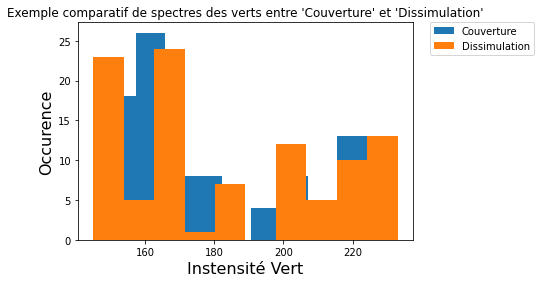

In [ ]:
plt.hist(SpectrePixelV(df['Couverture'][2]),label="Couverture")
plt.hist(SpectrePixelV(df['Dissimulation'][2]),label="Dissimulation")
plt.xlabel("Instensité Vert", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Exemple comparatif de spectres des verts entre 'Couverture' et 'Dissimulation'")

Text(0.5, 1.0, "Exemple comparatif de spectres des bleus entre 'Couverture' et 'Dissimulation'")

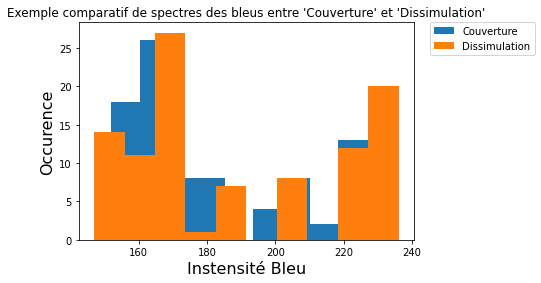

In [ ]:
plt.hist(SpectrePixelB(df['Couverture'][2]),label="Couverture")
plt.hist(SpectrePixelB(df['Dissimulation'][2]),label="Dissimulation")
plt.xlabel("Instensité Bleu", fontsize=16)  
plt.ylabel("Occurence", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Exemple comparatif de spectres des bleus entre 'Couverture' et 'Dissimulation'")

On remarque comme précédemment que les distances sont relativement faibles entre 'Dissimulation' et 'Couverture'. Les spectres sont aussi très similaires. Encore une fois, la méthode "LSB" modifie peu les images de base et de couverture. Ainsi cette méthode est à la fois peu soupçonnable et distord peu l'information secrète.

# Modélisation 1: approche sans paramètre positionnel.
On suppose ici qu'il n'y a pas de permutation sur les pixels, on néglige donc le paramètre positionnel des pixels. Nos premières tentatives en entrainant différents algorithmes sur l'ensemble des bits (donc 256 classes) étaient peu fructueuses (mauvais score ou temps de calcul trop important). On a donc décidé de décomposer le problème en entrainant un modèle pour chaque bit (2 classes à chaque fois). Aprés plusieurs essais (k plus proche voisin, classifier Bayesien, SVM, ...) le mlpclassifier s'est clairement détaché. Les résultats sont trés concluants (prédiction parfaite des bits de poids fort). 


In [ ]:
##Preliminaire technique##
def Decoupepixel(df):
  L1=[]
  L2=[]
  L3=[]
  for i in range(len(df['Base'])):
    for j in range(len(df['Base'][0])):
          for l in range(len(df['Base'][0][0])):
            L1.append(df['Base'][i][j][l])
            L2.append(df['Dissimulation'][i][j][l])
            L3.append(df['Récupération'][i][j][l])

  Lb=[]
  for x in L2:
    Lb.append([list(binaire(x[0],8).strip()),list(binaire(x[1],8).strip()),list(binaire(x[2],8).strip())])

  Lb1=[]
  for x in Lb:
    Lb1.append ([float(x[0][0]),float(x[0][1]),float(x[0][2]),float(x[0][3]),float(x[0][4]),float(x[0][5]),float(x[0][6]),float(x[0][7]),float(x[1][0]),float(x[1][1]),float(x[1][2]),float(x[1][3]),float(x[1][4]),float(x[1][5]),float(x[1][6]),float(x[1][7]),float(x[2][0]),float(x[2][1]),float(x[2][2]),float(x[2][3]),float(x[2][4]),float(x[2][5]),float(x[2][6]),float(x[2][7])])

  df2=pandas.DataFrame({"Pixel Dissimulation": Lb1})
  for i in range(3):
    for j in range(8):
      Lb2=[]
      for x in L1:
        Lb2.append([list(binaire(x[0],8).strip()),list(binaire(x[1],8).strip()),list(binaire(x[2],8).strip())])
      Lb12=[]
      for x in Lb2:
        Lb12.append(float(x[i][j]))
      a='bit'+str(i)+str(j)
      df2.insert(loc=0,column=a, value=Lb12)
  return(df2)

In [ ]:
df2=Decoupepixel(df)

In [ ]:
df2

,bit27,bit26,bit25,bit24,bit23,bit22,bit21,bit20,bit17,bit16,bit15,bit14,bit13,bit12,bit11,bit10,bit07,bit06,bit05,bit04,bit03,bit02,bit01,bit00,Pixel Dissimulation
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ..."
4,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
9996,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
9997,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
9998,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."


In [ ]:
def classifier24bit(df):
  df = df.sample(frac = 1) 
  df_train = df.head(5000)
  df_test = df.tail(5000)
  L=[]
  for i in range(3):
    for j in range(8):
      lf = MLPClassifier(hidden_layer_sizes=(100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
      lf.fit(df_train['Pixel Dissimulation'].values.tolist(),df_train['bit'+str(i)+str(j)])
      L.append(lf.score(df_test['Pixel Dissimulation'].values.tolist(),df_test['bit'+str(i)+str(j)]))
  return(L)
Rc=classifier24bit(df2)

Iteration 1, loss = 0.69660555
Iteration 2, loss = 0.65736383
Iteration 3, loss = 0.62041520
Iteration 4, loss = 0.58622779
Iteration 5, loss = 0.55379277
Iteration 6, loss = 0.52266775
Iteration 7, loss = 0.49244017
Iteration 8, loss = 0.46317792
Iteration 9, loss = 0.43480920
Iteration 10, loss = 0.40753571
Iteration 11, loss = 0.38146139
Iteration 12, loss = 0.35674567
Iteration 13, loss = 0.33355832
Iteration 14, loss = 0.31185344
Iteration 15, loss = 0.29164227
Iteration 16, loss = 0.27296235
Iteration 17, loss = 0.25575654
Iteration 18, loss = 0.23995159
Iteration 19, loss = 0.22544289
Iteration 20, loss = 0.21214353
Iteration 21, loss = 0.19993229
Iteration 22, loss = 0.18874803
Iteration 23, loss = 0.17844893
Iteration 24, loss = 0.16900315
Iteration 25, loss = 0.16028434
Iteration 26, loss = 0.15223819
Iteration 27, loss = 0.14479316
Iteration 28, loss = 0.13789764
Iteration 29, loss = 0.13147711
Iteration 30, loss = 0.12550887
Iteration 31, loss = 0.11995193
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.68551198
Iteration 2, loss = 0.64658145
Iteration 3, loss = 0.61724163
Iteration 4, loss = 0.59145122
Iteration 5, loss = 0.56692993
Iteration 6, loss = 0.54300930
Iteration 7, loss = 0.51957393
Iteration 8, loss = 0.49646549
Iteration 9, loss = 0.47377758
Iteration 10, loss = 0.45159661
Iteration 11, loss = 0.42991066
Iteration 12, loss = 0.40894880
Iteration 13, loss = 0.38872421
Iteration 14, loss = 0.36934854
Iteration 15, loss = 0.35054297
Iteration 16, loss = 0.33269652
Iteration 17, loss = 0.31572943
Iteration 18, loss = 0.29958970
Iteration 19, loss = 0.28430282
Iteration 20, loss = 0.26985000
Iteration 21, loss = 0.25619273
Iteration 22, loss = 0.24328484
Iteration 23, loss = 0.23114906
Iteration 24, loss = 0.21969570
Iteration 25, loss = 0.20886211
Iteration 26, loss = 0.19868477
Iteration 27, loss = 0.18915633
Iteration 28, loss = 0.18012342
Iteration 29, loss = 0.17165383
Iteration 30, loss = 0.16368057
Iteration 31, loss = 0.15618799
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 0.63331950
Iteration 4, loss = 0.60792580
Iteration 5, loss = 0.58417056
Iteration 6, loss = 0.56088655
Iteration 7, loss = 0.53802644
Iteration 8, loss = 0.51536413
Iteration 9, loss = 0.49290548
Iteration 10, loss = 0.47065419
Iteration 11, loss = 0.44868091
Iteration 12, loss = 0.42707448
Iteration 13, loss = 0.40589096
Iteration 14, loss = 0.38528134
Iteration 15, loss = 0.36512492
Iteration 16, loss = 0.34578262
Iteration 17, loss = 0.32715949
Iteration 18, loss = 0.30937738
Iteration 19, loss = 0.29243795
Iteration 20, loss = 0.27640329
Iteration 21, loss = 0.26125289
Iteration 22, loss = 0.24699895
Iteration 23, loss = 0.23356367
Iteration 24, loss = 0.22099111
Iteration 25, loss = 0.20915778
Iteration 26, loss = 0.19810474
Iteration 27, loss = 0.18776502
Iteration 28, loss = 0.17807894
Iteration 29, loss = 0.16902808
Iteration 30, loss = 0.16054958
Iteration 31, loss = 0.15266634
Iteration 32, loss = 0.14525266
Iteration 33, loss = 0.13835543
Iteration 34, l

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.71144286
Iteration 2, loss = 0.68279096
Iteration 3, loss = 0.66029453
Iteration 4, loss = 0.64053095
Iteration 5, loss = 0.62148477
Iteration 6, loss = 0.60291673
Iteration 7, loss = 0.58446574
Iteration 8, loss = 0.56608700
Iteration 9, loss = 0.54775236
Iteration 10, loss = 0.52926959
Iteration 11, loss = 0.51061063
Iteration 12, loss = 0.49179042
Iteration 13, loss = 0.47294387
Iteration 14, loss = 0.45408236
Iteration 15, loss = 0.43524844
Iteration 16, loss = 0.41650815
Iteration 17, loss = 0.39788747
Iteration 18, loss = 0.37961120
Iteration 19, loss = 0.36170116
Iteration 20, loss = 0.34416598
Iteration 21, loss = 0.32719407
Iteration 22, loss = 0.31068607
Iteration 23, loss = 0.29481293
Iteration 24, loss = 0.27961981
Iteration 25, loss = 0.26504874
Iteration 26, loss = 0.25118277
Iteration 27, loss = 0.23799699
Iteration 28, loss = 0.22555960
Iteration 29, loss = 0.21372423
Iteration 30, loss = 0.20259088
Iteration 31, loss = 0.19209614
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.70671230
Iteration 3, loss = 0.69884229
Iteration 4, loss = 0.69680367
Iteration 5, loss = 0.69592807
Iteration 6, loss = 0.69503470
Iteration 7, loss = 0.69424131
Iteration 8, loss = 0.69352623
Iteration 9, loss = 0.69287272
Iteration 10, loss = 0.69225083
Iteration 11, loss = 0.69166574
Iteration 12, loss = 0.69113872
Iteration 13, loss = 0.69058830
Iteration 14, loss = 0.69012033
Iteration 15, loss = 0.68963219
Iteration 16, loss = 0.68925016
Iteration 17, loss = 0.68883474
Iteration 18, loss = 0.68843206
Iteration 19, loss = 0.68807536
Iteration 20, loss = 0.68771141
Iteration 21, loss = 0.68743045
Iteration 22, loss = 0.68710981
Iteration 23, loss = 0.68678553
Iteration 24, loss = 0.68648557
Iteration 25, loss = 0.68620481
Iteration 26, loss = 0.68598049
Iteration 27, loss = 0.68574770
Iteration 28, loss = 0.68543131
Iteration 29, loss = 0.68523604
Iteration 30, loss = 0.68502700
Iteration 31, loss = 0.68476779
Iteration 32, loss = 0.68458480
Iteration 33, lo

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 6, loss = 0.69474288
Iteration 7, loss = 0.69433057
Iteration 8, loss = 0.69398228
Iteration 9, loss = 0.69357881
Iteration 10, loss = 0.69328190
Iteration 11, loss = 0.69297488
Iteration 12, loss = 0.69271914
Iteration 13, loss = 0.69244467
Iteration 14, loss = 0.69217233
Iteration 15, loss = 0.69192261
Iteration 16, loss = 0.69169484
Iteration 17, loss = 0.69149047
Iteration 18, loss = 0.69129353
Iteration 19, loss = 0.69109998
Iteration 20, loss = 0.69090074
Iteration 21, loss = 0.69072391
Iteration 22, loss = 0.69056808
Iteration 23, loss = 0.69039953
Iteration 24, loss = 0.69023801
Iteration 25, loss = 0.69010487
Iteration 26, loss = 0.68993679
Iteration 27, loss = 0.68981271
Iteration 28, loss = 0.68966858
Iteration 29, loss = 0.68956210
Iteration 30, loss = 0.68943902
Iteration 31, loss = 0.68931937
Iteration 32, loss = 0.68918681
Iteration 33, loss = 0.68908992
Iteration 34, loss = 0.68901323
Iteration 35, loss = 0.68886677
Iteration 36, loss = 0.68883884
Iteration 37

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 5, loss = 0.69688395
Iteration 6, loss = 0.69635342
Iteration 7, loss = 0.69587812
Iteration 8, loss = 0.69545253
Iteration 9, loss = 0.69506212
Iteration 10, loss = 0.69472230
Iteration 11, loss = 0.69439129
Iteration 12, loss = 0.69394317
Iteration 13, loss = 0.69369910
Iteration 14, loss = 0.69334216
Iteration 15, loss = 0.69304721
Iteration 16, loss = 0.69276592
Iteration 17, loss = 0.69254232
Iteration 18, loss = 0.69228276
Iteration 19, loss = 0.69204037
Iteration 20, loss = 0.69182345
Iteration 21, loss = 0.69164003
Iteration 22, loss = 0.69144309
Iteration 23, loss = 0.69124445
Iteration 24, loss = 0.69103718
Iteration 25, loss = 0.69086147
Iteration 26, loss = 0.69069585
Iteration 27, loss = 0.69053912
Iteration 28, loss = 0.69039069
Iteration 29, loss = 0.69026819
Iteration 30, loss = 0.69009667
Iteration 31, loss = 0.68997551
Iteration 32, loss = 0.68985044
Iteration 33, loss = 0.68968896
Iteration 34, loss = 0.68958215
Iteration 35, loss = 0.68946706
Iteration 36,

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.74102685
Iteration 2, loss = 0.70893507
Iteration 3, loss = 0.70056488
Iteration 4, loss = 0.69836693
Iteration 5, loss = 0.69719983
Iteration 6, loss = 0.69618214
Iteration 7, loss = 0.69529587
Iteration 8, loss = 0.69445430
Iteration 9, loss = 0.69374358
Iteration 10, loss = 0.69299172
Iteration 11, loss = 0.69232117
Iteration 12, loss = 0.69173375
Iteration 13, loss = 0.69115185
Iteration 14, loss = 0.69063298
Iteration 15, loss = 0.69013317
Iteration 16, loss = 0.68976823
Iteration 17, loss = 0.68931235
Iteration 18, loss = 0.68885645
Iteration 19, loss = 0.68845669
Iteration 20, loss = 0.68813584
Iteration 21, loss = 0.68777230
Iteration 22, loss = 0.68743013
Iteration 23, loss = 0.68712165
Iteration 24, loss = 0.68683468
Iteration 25, loss = 0.68658422
Iteration 26, loss = 0.68627706
Iteration 27, loss = 0.68603310
Iteration 28, loss = 0.68583095
Iteration 29, loss = 0.68562152
Iteration 30, loss = 0.68534302
Iteration 31, loss = 0.68512816
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.68964139
Iteration 2, loss = 0.64981376
Iteration 3, loss = 0.61079390
Iteration 4, loss = 0.57404958
Iteration 5, loss = 0.53907928
Iteration 6, loss = 0.50531731
Iteration 7, loss = 0.47243569
Iteration 8, loss = 0.44049053
Iteration 9, loss = 0.40945039
Iteration 10, loss = 0.37970092
Iteration 11, loss = 0.35133052
Iteration 12, loss = 0.32450102
Iteration 13, loss = 0.29935841
Iteration 14, loss = 0.27604101
Iteration 15, loss = 0.25440106
Iteration 16, loss = 0.23466347
Iteration 17, loss = 0.21657888
Iteration 18, loss = 0.20014707
Iteration 19, loss = 0.18521248
Iteration 20, loss = 0.17172622
Iteration 21, loss = 0.15953197
Iteration 22, loss = 0.14852361
Iteration 23, loss = 0.13855580
Iteration 24, loss = 0.12954749
Iteration 25, loss = 0.12136878
Iteration 26, loss = 0.11396103
Iteration 27, loss = 0.10721418
Iteration 28, loss = 0.10106642
Iteration 29, loss = 0.09543889
Iteration 30, loss = 0.09030675
Iteration 31, loss = 0.08560126
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.65687235
Iteration 2, loss = 0.62231415
Iteration 3, loss = 0.59175692
Iteration 4, loss = 0.56346128
Iteration 5, loss = 0.53627086
Iteration 6, loss = 0.50979430
Iteration 7, loss = 0.48404153
Iteration 8, loss = 0.45878211
Iteration 9, loss = 0.43424708
Iteration 10, loss = 0.41044426
Iteration 11, loss = 0.38754099
Iteration 12, loss = 0.36563501
Iteration 13, loss = 0.34486533
Iteration 14, loss = 0.32524812
Iteration 15, loss = 0.30676133
Iteration 16, loss = 0.28941451
Iteration 17, loss = 0.27316459
Iteration 18, loss = 0.25800777
Iteration 19, loss = 0.24392533
Iteration 20, loss = 0.23085049
Iteration 21, loss = 0.21864452
Iteration 22, loss = 0.20734200
Iteration 23, loss = 0.19683005
Iteration 24, loss = 0.18707136
Iteration 25, loss = 0.17794550
Iteration 26, loss = 0.16946446
Iteration 27, loss = 0.16152676
Iteration 28, loss = 0.15412188
Iteration 29, loss = 0.14718224
Iteration 30, loss = 0.14069951
Iteration 31, loss = 0.13461692
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.73278105
Iteration 2, loss = 0.69448095
Iteration 3, loss = 0.66466362
Iteration 4, loss = 0.63880164
Iteration 5, loss = 0.61449027
Iteration 6, loss = 0.59105187
Iteration 7, loss = 0.56811379
Iteration 8, loss = 0.54562350
Iteration 9, loss = 0.52354274
Iteration 10, loss = 0.50179673
Iteration 11, loss = 0.48047570
Iteration 12, loss = 0.45954181
Iteration 13, loss = 0.43905837
Iteration 14, loss = 0.41908267
Iteration 15, loss = 0.39971696
Iteration 16, loss = 0.38105519
Iteration 17, loss = 0.36311208
Iteration 18, loss = 0.34578118
Iteration 19, loss = 0.32932152
Iteration 20, loss = 0.31356563
Iteration 21, loss = 0.29854397
Iteration 22, loss = 0.28426904
Iteration 23, loss = 0.27066748
Iteration 24, loss = 0.25785180
Iteration 25, loss = 0.24564766
Iteration 26, loss = 0.23413352
Iteration 27, loss = 0.22321460
Iteration 28, loss = 0.21289685
Iteration 29, loss = 0.20312981
Iteration 30, loss = 0.19388379
Iteration 31, loss = 0.18517285
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70018498
Iteration 2, loss = 0.66219673
Iteration 3, loss = 0.63341145
Iteration 4, loss = 0.60945231
Iteration 5, loss = 0.58677909
Iteration 6, loss = 0.56476425
Iteration 7, loss = 0.54311943
Iteration 8, loss = 0.52168879
Iteration 9, loss = 0.50045831
Iteration 10, loss = 0.47942925
Iteration 11, loss = 0.45850211
Iteration 12, loss = 0.43778698
Iteration 13, loss = 0.41744230
Iteration 14, loss = 0.39753861
Iteration 15, loss = 0.37812231
Iteration 16, loss = 0.35925072
Iteration 17, loss = 0.34104305
Iteration 18, loss = 0.32354330
Iteration 19, loss = 0.30684660
Iteration 20, loss = 0.29085989
Iteration 21, loss = 0.27568329
Iteration 22, loss = 0.26130120
Iteration 23, loss = 0.24769573
Iteration 24, loss = 0.23487548
Iteration 25, loss = 0.22274247
Iteration 26, loss = 0.21134390
Iteration 27, loss = 0.20062683
Iteration 28, loss = 0.19056185
Iteration 29, loss = 0.18111257
Iteration 30, loss = 0.17225887
Iteration 31, loss = 0.16394938
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 5, loss = 0.68947304
Iteration 6, loss = 0.68868926
Iteration 7, loss = 0.68793062
Iteration 8, loss = 0.68730288
Iteration 9, loss = 0.68657260
Iteration 10, loss = 0.68599547
Iteration 11, loss = 0.68537196
Iteration 12, loss = 0.68485395
Iteration 13, loss = 0.68430934
Iteration 14, loss = 0.68381011
Iteration 15, loss = 0.68335722
Iteration 16, loss = 0.68287207
Iteration 17, loss = 0.68247752
Iteration 18, loss = 0.68209987
Iteration 19, loss = 0.68167418
Iteration 20, loss = 0.68131328
Iteration 21, loss = 0.68096177
Iteration 22, loss = 0.68058296
Iteration 23, loss = 0.68031680
Iteration 24, loss = 0.67994863
Iteration 25, loss = 0.67968905
Iteration 26, loss = 0.67938505
Iteration 27, loss = 0.67905605
Iteration 28, loss = 0.67879755
Iteration 29, loss = 0.67854940
Iteration 30, loss = 0.67830536
Iteration 31, loss = 0.67802647
Iteration 32, loss = 0.67779307
Iteration 33, loss = 0.67758169
Iteration 34, loss = 0.67736489
Iteration 35, loss = 0.67716454
Iteration 36,

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.72435774
Iteration 2, loss = 0.70619030
Iteration 3, loss = 0.70076629
Iteration 4, loss = 0.69954304
Iteration 5, loss = 0.69870911
Iteration 6, loss = 0.69804841
Iteration 7, loss = 0.69745301
Iteration 8, loss = 0.69680502
Iteration 9, loss = 0.69629015
Iteration 10, loss = 0.69578790
Iteration 11, loss = 0.69529340
Iteration 12, loss = 0.69494549
Iteration 13, loss = 0.69445434
Iteration 14, loss = 0.69413264
Iteration 15, loss = 0.69372132
Iteration 16, loss = 0.69337412
Iteration 17, loss = 0.69305131
Iteration 18, loss = 0.69280287
Iteration 19, loss = 0.69251149
Iteration 20, loss = 0.69219238
Iteration 21, loss = 0.69201846
Iteration 22, loss = 0.69166801
Iteration 23, loss = 0.69150403
Iteration 24, loss = 0.69121436
Iteration 25, loss = 0.69103980
Iteration 26, loss = 0.69083483
Iteration 27, loss = 0.69062421
Iteration 28, loss = 0.69039917
Iteration 29, loss = 0.69023414
Iteration 30, loss = 0.69003534
Iteration 31, loss = 0.68987341
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.73342860
Iteration 2, loss = 0.70970512
Iteration 3, loss = 0.70314833
Iteration 4, loss = 0.70158085
Iteration 5, loss = 0.70066170
Iteration 6, loss = 0.69996633
Iteration 7, loss = 0.69929436
Iteration 8, loss = 0.69863899
Iteration 9, loss = 0.69802731
Iteration 10, loss = 0.69752068
Iteration 11, loss = 0.69713689
Iteration 12, loss = 0.69644815
Iteration 13, loss = 0.69600828
Iteration 14, loss = 0.69562048
Iteration 15, loss = 0.69513898
Iteration 16, loss = 0.69472808
Iteration 17, loss = 0.69434060
Iteration 18, loss = 0.69398355
Iteration 19, loss = 0.69362091
Iteration 20, loss = 0.69331138
Iteration 21, loss = 0.69296881
Iteration 22, loss = 0.69268454
Iteration 23, loss = 0.69238581
Iteration 24, loss = 0.69211147
Iteration 25, loss = 0.69183590
Iteration 26, loss = 0.69159927
Iteration 27, loss = 0.69133999
Iteration 28, loss = 0.69109773
Iteration 29, loss = 0.69087676
Iteration 30, loss = 0.69063472
Iteration 31, loss = 0.69040443
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.73379595
Iteration 2, loss = 0.71000668
Iteration 3, loss = 0.70315777
Iteration 4, loss = 0.70140997
Iteration 5, loss = 0.70038301
Iteration 6, loss = 0.69958581
Iteration 7, loss = 0.69879193
Iteration 8, loss = 0.69811348
Iteration 9, loss = 0.69751303
Iteration 10, loss = 0.69690871
Iteration 11, loss = 0.69633734
Iteration 12, loss = 0.69585852
Iteration 13, loss = 0.69537616
Iteration 14, loss = 0.69494589
Iteration 15, loss = 0.69458019
Iteration 16, loss = 0.69413415
Iteration 17, loss = 0.69376993
Iteration 18, loss = 0.69342137
Iteration 19, loss = 0.69309160
Iteration 20, loss = 0.69278517
Iteration 21, loss = 0.69248676
Iteration 22, loss = 0.69227255
Iteration 23, loss = 0.69194760
Iteration 24, loss = 0.69171680
Iteration 25, loss = 0.69147140
Iteration 26, loss = 0.69124734
Iteration 27, loss = 0.69104896
Iteration 28, loss = 0.69081894
Iteration 29, loss = 0.69062145
Iteration 30, loss = 0.69053901
Iteration 31, loss = 0.69027438
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.58354127
Iteration 5, loss = 0.55510197
Iteration 6, loss = 0.52783813
Iteration 7, loss = 0.50123615
Iteration 8, loss = 0.47534432
Iteration 9, loss = 0.45005346
Iteration 10, loss = 0.42554845
Iteration 11, loss = 0.40183430
Iteration 12, loss = 0.37896716
Iteration 13, loss = 0.35716221
Iteration 14, loss = 0.33645770
Iteration 15, loss = 0.31684045
Iteration 16, loss = 0.29850057
Iteration 17, loss = 0.28132770
Iteration 18, loss = 0.26539103
Iteration 19, loss = 0.25054994
Iteration 20, loss = 0.23678768
Iteration 21, loss = 0.22406300
Iteration 22, loss = 0.21225859
Iteration 23, loss = 0.20132457
Iteration 24, loss = 0.19121912
Iteration 25, loss = 0.18178168
Iteration 26, loss = 0.17305481
Iteration 27, loss = 0.16489350
Iteration 28, loss = 0.15731030
Iteration 29, loss = 0.15018807
Iteration 30, loss = 0.14353703
Iteration 31, loss = 0.13732872
Iteration 32, loss = 0.13148095
Iteration 33, loss = 0.12598677
Iteration 34, loss = 0.12082542
Iteration 35, 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.61889765
Iteration 3, loss = 0.58925437
Iteration 4, loss = 0.56157636
Iteration 5, loss = 0.53484756
Iteration 6, loss = 0.50882769
Iteration 7, loss = 0.48345332
Iteration 8, loss = 0.45857141
Iteration 9, loss = 0.43451505
Iteration 10, loss = 0.41116329
Iteration 11, loss = 0.38873614
Iteration 12, loss = 0.36720928
Iteration 13, loss = 0.34667052
Iteration 14, loss = 0.32725653
Iteration 15, loss = 0.30880503
Iteration 16, loss = 0.29155275
Iteration 17, loss = 0.27534028
Iteration 18, loss = 0.26021516
Iteration 19, loss = 0.24607796
Iteration 20, loss = 0.23295483
Iteration 21, loss = 0.22070891
Iteration 22, loss = 0.20934140
Iteration 23, loss = 0.19878690
Iteration 24, loss = 0.18892814
Iteration 25, loss = 0.17975221
Iteration 26, loss = 0.17120767
Iteration 27, loss = 0.16323408
Iteration 28, loss = 0.15579691
Iteration 29, loss = 0.14881830
Iteration 30, loss = 0.14230721
Iteration 31, loss = 0.13619556
Iteration 32, loss = 0.13044743
Iteration 33, lo

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.71475187
Iteration 2, loss = 0.67373305
Iteration 3, loss = 0.64291275
Iteration 4, loss = 0.61646122
Iteration 5, loss = 0.59149336
Iteration 6, loss = 0.56714097
Iteration 7, loss = 0.54324546
Iteration 8, loss = 0.51959465
Iteration 9, loss = 0.49636241
Iteration 10, loss = 0.47343242
Iteration 11, loss = 0.45089988
Iteration 12, loss = 0.42887670
Iteration 13, loss = 0.40744859
Iteration 14, loss = 0.38663600
Iteration 15, loss = 0.36649559
Iteration 16, loss = 0.34718551
Iteration 17, loss = 0.32867124
Iteration 18, loss = 0.31110430
Iteration 19, loss = 0.29432576
Iteration 20, loss = 0.27848658
Iteration 21, loss = 0.26352988
Iteration 22, loss = 0.24945519
Iteration 23, loss = 0.23625194
Iteration 24, loss = 0.22385147
Iteration 25, loss = 0.21219021
Iteration 26, loss = 0.20129345
Iteration 27, loss = 0.19109326
Iteration 28, loss = 0.18154144
Iteration 29, loss = 0.17257320
Iteration 30, loss = 0.16417346
Iteration 31, loss = 0.15630563
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 5, loss = 0.59301094
Iteration 6, loss = 0.57210628
Iteration 7, loss = 0.55145723
Iteration 8, loss = 0.53094560
Iteration 9, loss = 0.51057956
Iteration 10, loss = 0.49037361
Iteration 11, loss = 0.47018009
Iteration 12, loss = 0.45017076
Iteration 13, loss = 0.43040131
Iteration 14, loss = 0.41098211
Iteration 15, loss = 0.39199294
Iteration 16, loss = 0.37339424
Iteration 17, loss = 0.35542827
Iteration 18, loss = 0.33802338
Iteration 19, loss = 0.32128268
Iteration 20, loss = 0.30516329
Iteration 21, loss = 0.28975653
Iteration 22, loss = 0.27507862
Iteration 23, loss = 0.26111636
Iteration 24, loss = 0.24782979
Iteration 25, loss = 0.23524546
Iteration 26, loss = 0.22338585
Iteration 27, loss = 0.21213271
Iteration 28, loss = 0.20153052
Iteration 29, loss = 0.19153040
Iteration 30, loss = 0.18213604
Iteration 31, loss = 0.17329250
Iteration 32, loss = 0.16496846
Iteration 33, loss = 0.15714757
Iteration 34, loss = 0.14983014
Iteration 35, loss = 0.14289398
Iteration 36,

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.70039283
Iteration 5, loss = 0.69924521
Iteration 6, loss = 0.69825868
Iteration 7, loss = 0.69726339
Iteration 8, loss = 0.69638100
Iteration 9, loss = 0.69551384
Iteration 10, loss = 0.69477527
Iteration 11, loss = 0.69397142
Iteration 12, loss = 0.69326454
Iteration 13, loss = 0.69266009
Iteration 14, loss = 0.69202943
Iteration 15, loss = 0.69143549
Iteration 16, loss = 0.69082618
Iteration 17, loss = 0.69028995
Iteration 18, loss = 0.68981425
Iteration 19, loss = 0.68927228
Iteration 20, loss = 0.68884044
Iteration 21, loss = 0.68838455
Iteration 22, loss = 0.68791718
Iteration 23, loss = 0.68752034
Iteration 24, loss = 0.68713049
Iteration 25, loss = 0.68673554
Iteration 26, loss = 0.68642222
Iteration 27, loss = 0.68607255
Iteration 28, loss = 0.68570988
Iteration 29, loss = 0.68536675
Iteration 30, loss = 0.68505547
Iteration 31, loss = 0.68478502
Iteration 32, loss = 0.68443125
Iteration 33, loss = 0.68415302
Iteration 34, loss = 0.68391105
Iteration 35, 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 5, loss = 0.70279785
Iteration 6, loss = 0.70196225
Iteration 7, loss = 0.70122113
Iteration 8, loss = 0.70051815
Iteration 9, loss = 0.69981476
Iteration 10, loss = 0.69920675
Iteration 11, loss = 0.69864548
Iteration 12, loss = 0.69821114
Iteration 13, loss = 0.69759728
Iteration 14, loss = 0.69719797
Iteration 15, loss = 0.69668405
Iteration 16, loss = 0.69625221
Iteration 17, loss = 0.69584836
Iteration 18, loss = 0.69546334
Iteration 19, loss = 0.69511214
Iteration 20, loss = 0.69477212
Iteration 21, loss = 0.69441995
Iteration 22, loss = 0.69411135
Iteration 23, loss = 0.69376774
Iteration 24, loss = 0.69346578
Iteration 25, loss = 0.69320436
Iteration 26, loss = 0.69293468
Iteration 27, loss = 0.69267946
Iteration 28, loss = 0.69247745
Iteration 29, loss = 0.69219096
Iteration 30, loss = 0.69194620
Iteration 31, loss = 0.69172145
Iteration 32, loss = 0.69151828
Iteration 33, loss = 0.69129278
Iteration 34, loss = 0.69108423
Iteration 35, loss = 0.69091444
Iteration 36,

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.69462450
Iteration 5, loss = 0.69392934
Iteration 6, loss = 0.69332486
Iteration 7, loss = 0.69274217
Iteration 8, loss = 0.69219613
Iteration 9, loss = 0.69169527
Iteration 10, loss = 0.69125260
Iteration 11, loss = 0.69098013
Iteration 12, loss = 0.69035940
Iteration 13, loss = 0.68994589
Iteration 14, loss = 0.68956891
Iteration 15, loss = 0.68920963
Iteration 16, loss = 0.68887164
Iteration 17, loss = 0.68859744
Iteration 18, loss = 0.68820200
Iteration 19, loss = 0.68791106
Iteration 20, loss = 0.68762624
Iteration 21, loss = 0.68734832
Iteration 22, loss = 0.68708050
Iteration 23, loss = 0.68682084
Iteration 24, loss = 0.68658107
Iteration 25, loss = 0.68634311
Iteration 26, loss = 0.68615900
Iteration 27, loss = 0.68588798
Iteration 28, loss = 0.68567915
Iteration 29, loss = 0.68546978
Iteration 30, loss = 0.68525013
Iteration 31, loss = 0.68509625
Iteration 32, loss = 0.68489486
Iteration 33, loss = 0.68477210
Iteration 34, loss = 0.68455643
Iteration 35, 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.71042513
Iteration 3, loss = 0.70166247
Iteration 4, loss = 0.69947698
Iteration 5, loss = 0.69824559
Iteration 6, loss = 0.69723407
Iteration 7, loss = 0.69626733
Iteration 8, loss = 0.69541601
Iteration 9, loss = 0.69462603
Iteration 10, loss = 0.69384078
Iteration 11, loss = 0.69318389
Iteration 12, loss = 0.69251530
Iteration 13, loss = 0.69194947
Iteration 14, loss = 0.69136737
Iteration 15, loss = 0.69085182
Iteration 16, loss = 0.69035001
Iteration 17, loss = 0.68987887
Iteration 18, loss = 0.68951837
Iteration 19, loss = 0.68903620
Iteration 20, loss = 0.68868131
Iteration 21, loss = 0.68832874
Iteration 22, loss = 0.68794326
Iteration 23, loss = 0.68765773
Iteration 24, loss = 0.68734625
Iteration 25, loss = 0.68703493
Iteration 26, loss = 0.68676045
Iteration 27, loss = 0.68654106
Iteration 28, loss = 0.68626701
Iteration 29, loss = 0.68601103
Iteration 30, loss = 0.68574509
Iteration 31, loss = 0.68555232
Iteration 32, loss = 0.68533265
Iteration 33, lo

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
Rc

[1.0,
 1.0,
 1.0,
 1.0,
 0.5872,
 0.5562,
 0.5534,
 0.5576,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6248,
 0.5664,
 0.5634,
 0.5812,
 1.0,
 1.0,
 1.0,
 1.0,
 0.616,
 0.571,
 0.5796,
 0.585]

Text(0, 0.5, 'Score')

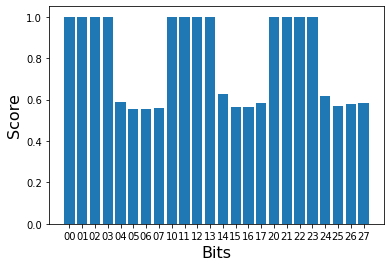

In [ ]:
Ylf=Rc
Xlf=['00','01','02','03','04','05','06','07','10','11','12','13','14','15','16','17','20','21','22','23','24','25','26','27']
plt.bar(Xlf,Ylf)
plt.xlabel("Bits", fontsize=16)  
plt.ylabel("Score", fontsize=16)

**En résumé**

On a une trés bonne prédiction (Score de 1) pour les bits de poids fort de la base (qui est ce qu'on cherche à retrouver) et une prédiction légèrement au-dessus du "pile ou face" sur les bits de poids faible (ce qui est est cohérent l'information étant supprimée par la méthode LSB, le score légèrement supérieur à 0.5 peut s'expliquer par la non-uniformité de la distribution des intensités de chaque couleur constatée précédement). Eve peut donc accéder avec cette méthode aux messages secrets sans rien savoir à priori sur la méthode employée. La méthode 'LSB' seule n'est donc pas trés robuste face à ce type d'attaque. Voyons si cette approche fonctionne encore lorsqu'il y a prétraitement de l'image de base.

# Modélisation 2: Approche avec paramètre positionnel.
Dans cette partie, on se place dans le cadre plus génèral où il y a pu avoir permutation sur les pixels. On ajoute donc dans le dataframe des paramètres positionnels. 

In [ ]:
import random
import pickle
def melangeListImage(A,n):
  B=pickle.loads(pickle.dumps(A))
  for d in range(n):
    i=random.randrange(len(B[0][0]))
    j=random.randrange(len(B[0][0]))
    k=random.randrange(len(B[0][0]))
    l=random.randrange(len(B[0][0]))
    for u in range(len(B)):
      B[u][i][j], B[u][k][l] = B[u][k][l], B[u][i][j]
  return(B)  
  

In [ ]:

def max_perm(A,n,d):
  B=pickle.loads(pickle.dumps(A))
  for h in range(n):
    S=0
    T=0
    C=melangeListImage(B,d)
    for j in range(len(B)):

        T=T+np.linalg.norm(np.array(A[j])-np.array(B[j]))
        S=S+np.linalg.norm(np.array(A[j])-np.array(C[j]))
    if S>T:
      B=C
  return(B)



In [ ]:
##On mélange "suffisamment" les matrices dans Base ##

BaseMélange=max_perm(df['Base'],10,100)

##On gènere le dataframe correspondant en ajoutant les parametres de position du bit de sortie##

F1=[]
F2=[]
F3=[]
F4=[]
F5=[]
for i in range(len(df['Base'])):
  for j in range(len(df['Base'][0])):
        for l in range(len(df['Base'][0][0])):
          F1.append(df['Base'][i][j][l])
          F2.append(Dissimulation(BaseMélange[i],df['Couverture'][i]))
          F3.append(i)
          F4.append(j)
          F5.append(l)


df3=pandas.DataFrame({"Position ligne sortie" : F4,  "Position collonne sortie" : F5})
for i in range(3):
  for j in range(8):
    Fb2=[]
    for x in F1:
      Fb2.append([list(binaire(x[0],8).strip()),list(binaire(x[1],8).strip()),list(binaire(x[2],8).strip())])
    Fb12=[]
    for x in Fb2:
      Fb12.append(float(x[i][j]))
    a='bit'+str(i)+str(j)
    df3.insert(loc=0,column=a, value=Fb12)

for i in range(10):
  for j in range(10):
    for h in range(8):
      R=[]
      V=[]
      B=[]
      for k in range(100):
        for l in range(100):
          R.append(list(binaire(BaseMélange[k][i][j][0],8).strip())[h])
          V.append(list(binaire(BaseMélange[k][i][j][1],8).strip())[h])
          B.append(list(binaire(BaseMélange[k][i][j][2],8).strip())[h])
        
      aR='coef matrice init Rouge'+' '+str(i)+str(j)+str(h)
      aV='coef matrice init Vert'+' '+str(i)+str(j)+str(h)
      aB='coef matrice init Bleu'+' '+str(i)+str(j)+str(h)
      df3.insert(loc=0,column=aR, value=R)
      df3.insert(loc=0,column=aV, value=V)
      df3.insert(loc=0,column=aB, value=B)

In [ ]:
df3

,coef matrice init Bleu 997,coef matrice init Vert 997,coef matrice init Rouge 997,coef matrice init Bleu 996,coef matrice init Vert 996,coef matrice init Rouge 996,coef matrice init Bleu 995,coef matrice init Vert 995,coef matrice init Rouge 995,coef matrice init Bleu 994,coef matrice init Vert 994,coef matrice init Rouge 994,coef matrice init Bleu 993,coef matrice init Vert 993,coef matrice init Rouge 993,coef matrice init Bleu 992,coef matrice init Vert 992,coef matrice init Rouge 992,coef matrice init Bleu 991,coef matrice init Vert 991,coef matrice init Rouge 991,coef matrice init Bleu 990,coef matrice init Vert 990,coef matrice init Rouge 990,coef matrice init Bleu 987,coef matrice init Vert 987,coef matrice init Rouge 987,coef matrice init Bleu 986,coef matrice init Vert 986,coef matrice init Rouge 986,coef matrice init Bleu 985,coef matrice init Vert 985,coef matrice init Rouge 985,coef matrice init Bleu 984,coef matrice init Vert 984,coef matrice init Rouge 984,coef matrice init Bleu 983,coef matrice init Vert 983,coef matrice init Rouge 983,coef matrice init Bleu 982,...,coef matrice init Vert 004,coef matrice init Rouge 004,coef matrice init Bleu 003,coef matrice init Vert 003,coef matrice init Rouge 003,coef matrice init Bleu 002,coef matrice init Vert 002,coef matrice init Rouge 002,coef matrice init Bleu 001,coef matrice init Vert 001,coef matrice init Rouge 001,coef matrice init Bleu 000,coef matrice init Vert 000,coef matrice init Rouge 000,bit27,bit26,bit25,bit24,bit23,bit22,bit21,bit20,bit17,bit16,bit15,bit14,bit13,bit12,bit11,bit10,bit07,bit06,bit05,bit04,bit03,bit02,bit01,bit00,Position ligne sortie,Position collonne sortie
0,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0
1,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0,1
2,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,2
3,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,3
4,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,9,5
9996,1,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,9,6
9997,1,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,9,7
9998,1,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,9,8


In [ ]:
colonnes = []
for i in range(10):
  for j in range(10):
    for l in range(8):
      colonnes.append('coef matrice init Bleu'+' '+str(i)+str(j)+str(l))
      colonnes.append('coef matrice init Vert'+' '+str(i)+str(j)+str(l))
      colonnes.append('coef matrice init Rouge'+' '+str(i)+str(j)+str(l))
colonnes.append('Position ligne sortie')
colonnes.append('Position collonne sortie')


In [ ]:
def classifier24bit2(df):
  df = df.sample(frac = 1) 
  df_train = df.head(5000)
  df_test = df.tail(5000)
  L=[]
  for i in range(3):
    for j in range(8):
      lf = MLPClassifier(hidden_layer_sizes=(100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
      lf.fit(df_train[colonnes],df_train['bit'+str(i)+str(j)])
      L.append(lf.score(df_test[colonnes],df_test['bit'+str(i)+str(j)]))
  return(L)
Rc2=classifier24bit2(df3)

Iteration 1, loss = 0.54853188
Iteration 2, loss = 0.43719954
Iteration 3, loss = 0.41560077
Iteration 4, loss = 0.40439235
Iteration 5, loss = 0.39415411
Iteration 6, loss = 0.38782648
Iteration 7, loss = 0.38242014
Iteration 8, loss = 0.37853750
Iteration 9, loss = 0.37569118
Iteration 10, loss = 0.37269276
Iteration 11, loss = 0.37058651
Iteration 12, loss = 0.36944404
Iteration 13, loss = 0.36555798
Iteration 14, loss = 0.36412464
Iteration 15, loss = 0.36118039
Iteration 16, loss = 0.35872833
Iteration 17, loss = 0.35741321
Iteration 18, loss = 0.35444025
Iteration 19, loss = 0.35305656
Iteration 20, loss = 0.35159326
Iteration 21, loss = 0.34998059
Iteration 22, loss = 0.34688481
Iteration 23, loss = 0.34439150
Iteration 24, loss = 0.34324361
Iteration 25, loss = 0.34088471
Iteration 26, loss = 0.33966662
Iteration 27, loss = 0.33780162
Iteration 28, loss = 0.33587631
Iteration 29, loss = 0.33503092
Iteration 30, loss = 0.33266074
Iteration 31, loss = 0.33156245
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.67708201
Iteration 2, loss = 0.62541330
Iteration 3, loss = 0.61597369
Iteration 4, loss = 0.60952265
Iteration 5, loss = 0.60572264
Iteration 6, loss = 0.60382789
Iteration 7, loss = 0.60042040
Iteration 8, loss = 0.59717101
Iteration 9, loss = 0.59536660
Iteration 10, loss = 0.59314656
Iteration 11, loss = 0.58966313
Iteration 12, loss = 0.58733165
Iteration 13, loss = 0.58539076
Iteration 14, loss = 0.58277801
Iteration 15, loss = 0.57974437
Iteration 16, loss = 0.57740917
Iteration 17, loss = 0.57593438
Iteration 18, loss = 0.57320181
Iteration 19, loss = 0.56997319
Iteration 20, loss = 0.56639201
Iteration 21, loss = 0.56402682
Iteration 22, loss = 0.56252693
Iteration 23, loss = 0.55936563
Iteration 24, loss = 0.55751202
Iteration 25, loss = 0.55489467
Iteration 26, loss = 0.55342198
Iteration 27, loss = 0.55091048
Iteration 28, loss = 0.55028546
Iteration 29, loss = 0.54637963
Iteration 30, loss = 0.54396896
Iteration 31, loss = 0.54296814
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.67968037
Iteration 2, loss = 0.61594293
Iteration 3, loss = 0.60393286
Iteration 4, loss = 0.59641025
Iteration 5, loss = 0.59249173
Iteration 6, loss = 0.58871253
Iteration 7, loss = 0.58636578
Iteration 8, loss = 0.58337204
Iteration 9, loss = 0.58150574
Iteration 10, loss = 0.58090329
Iteration 11, loss = 0.57841460
Iteration 12, loss = 0.57649138
Iteration 13, loss = 0.57598391
Iteration 14, loss = 0.57332326
Iteration 15, loss = 0.57145387
Iteration 16, loss = 0.57190272
Iteration 17, loss = 0.56965196
Iteration 18, loss = 0.56721810
Iteration 19, loss = 0.56676145
Iteration 20, loss = 0.56542181
Iteration 21, loss = 0.56450081
Iteration 22, loss = 0.56238554
Iteration 23, loss = 0.56133697
Iteration 24, loss = 0.56084974
Iteration 25, loss = 0.55954835
Iteration 26, loss = 0.55762407
Iteration 27, loss = 0.55762393
Iteration 28, loss = 0.55680816
Iteration 29, loss = 0.55440659
Iteration 30, loss = 0.55349739
Iteration 31, loss = 0.55273709
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70929023
Iteration 2, loss = 0.66742731
Iteration 3, loss = 0.66395597
Iteration 4, loss = 0.66122453
Iteration 5, loss = 0.65961658
Iteration 6, loss = 0.65897684
Iteration 7, loss = 0.65732292
Iteration 8, loss = 0.65607418
Iteration 9, loss = 0.65625430
Iteration 10, loss = 0.65481145
Iteration 11, loss = 0.65421238
Iteration 12, loss = 0.65333776
Iteration 13, loss = 0.65364606
Iteration 14, loss = 0.65144550
Iteration 15, loss = 0.65149221
Iteration 16, loss = 0.65123735
Iteration 17, loss = 0.65053647
Iteration 18, loss = 0.65079350
Iteration 19, loss = 0.64956788
Iteration 20, loss = 0.64994739
Iteration 21, loss = 0.64857973
Iteration 22, loss = 0.64833641
Iteration 23, loss = 0.64903899
Iteration 24, loss = 0.64693374
Iteration 25, loss = 0.64717803
Iteration 26, loss = 0.64600495
Iteration 27, loss = 0.64649427
Iteration 28, loss = 0.64762854
Iteration 29, loss = 0.64477743
Iteration 30, loss = 0.64388327
Iteration 31, loss = 0.64430088
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.66804116
Iteration 2, loss = 0.62519888
Iteration 3, loss = 0.61820658
Iteration 4, loss = 0.61367861
Iteration 5, loss = 0.61202878
Iteration 6, loss = 0.60874620
Iteration 7, loss = 0.60582380
Iteration 8, loss = 0.60205526
Iteration 9, loss = 0.60190977
Iteration 10, loss = 0.59813534
Iteration 11, loss = 0.59542810
Iteration 12, loss = 0.59316950
Iteration 13, loss = 0.59198265
Iteration 14, loss = 0.58961643
Iteration 15, loss = 0.58560910
Iteration 16, loss = 0.58366209
Iteration 17, loss = 0.58252996
Iteration 18, loss = 0.57963739
Iteration 19, loss = 0.57685987
Iteration 20, loss = 0.57441574
Iteration 21, loss = 0.57217156
Iteration 22, loss = 0.57013733
Iteration 23, loss = 0.56697632
Iteration 24, loss = 0.56416342
Iteration 25, loss = 0.56204309
Iteration 26, loss = 0.56032209
Iteration 27, loss = 0.55762654
Iteration 28, loss = 0.55598421
Iteration 29, loss = 0.55275315
Iteration 30, loss = 0.55167797
Iteration 31, loss = 0.55035945
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.69742039
Iteration 2, loss = 0.68050608
Iteration 3, loss = 0.67636112
Iteration 4, loss = 0.67615192
Iteration 5, loss = 0.67631799
Iteration 6, loss = 0.67481482
Iteration 7, loss = 0.67423968
Iteration 8, loss = 0.67469436
Iteration 9, loss = 0.67470813
Iteration 10, loss = 0.67337210
Iteration 11, loss = 0.67293777
Iteration 12, loss = 0.67292554
Iteration 13, loss = 0.67247789
Iteration 14, loss = 0.67256581
Iteration 15, loss = 0.67209749
Iteration 16, loss = 0.67160251
Iteration 17, loss = 0.67248957
Iteration 18, loss = 0.67065272
Iteration 19, loss = 0.67144413
Iteration 20, loss = 0.67282538
Iteration 21, loss = 0.67001572
Iteration 22, loss = 0.67047637
Iteration 23, loss = 0.67076596
Iteration 24, loss = 0.66990963
Iteration 25, loss = 0.66989453
Iteration 26, loss = 0.67015229
Iteration 27, loss = 0.66985905
Iteration 28, loss = 0.66911507
Iteration 29, loss = 0.66886649
Iteration 30, loss = 0.66840259
Iteration 31, loss = 0.66940231
Iteration 32, los

In [ ]:
Rc2

[0.9476,
 0.7602,
 0.6446,
 0.6196,
 0.5792,
 0.5698,
 0.5584,
 0.5948,
 0.9298,
 0.8002,
 0.6832,
 0.6016,
 0.5526,
 0.5522,
 0.5794,
 0.5974,
 0.9464,
 0.7686,
 0.7026,
 0.6288,
 0.5932,
 0.591,
 0.5708,
 0.6174]

Text(0, 0.5, 'Score')

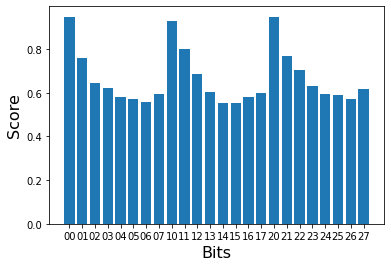

In [ ]:
Ylf=Rc2
Xlf=['00','01','02','03','04','05','06','07','10','11','12','13','14','15','16','17','20','21','22','23','24','25','26','27']
plt.bar(Xlf,Ylf)
plt.xlabel("Bits", fontsize=16)  
plt.ylabel("Score", fontsize=16)

On a utilisé ici un mlpclassifier de mêmes hyperparamètres que pour le cas sans permuation les résultats sont moins bons (seule la prédiction sur le premier bit fort de chaque couleur et éventuellement le deuxième sont satisfaisantes). Ajouter une permuation en amont rend donc le schéma plus robuste face à ce genre d'attaque. 0n essaie dans la suite d'ajuster les hyperparamètres pour augmenter le score de notre modèle.

In [ ]:
def classifier12bitFort(df):
  df = df.sample(frac = 1) 
  df_train = df.head(5000)
  df_test = df.tail(5000)
  L=[]
  for i in range(3):
    for j in range(4):
      lf = MLPClassifier(hidden_layer_sizes=(30,30,30,30,30), max_iter=2000, alpha=0.1,
                     solver='sgd', verbose=10,  random_state=21,n_iter_no_change=100)
      lf.fit(df_train[colonnes],df_train['bit'+str(i)+str(j)])
      L.append(lf.score(df_test[colonnes],df_test['bit'+str(i)+str(j)]))
  return(L)
Rc3=classifier12bitFort(df3)

Iteration 1, loss = 0.71655356
Iteration 2, loss = 0.63599743
Iteration 3, loss = 0.57281716
Iteration 4, loss = 0.53262885
Iteration 5, loss = 0.50217280
Iteration 6, loss = 0.47655128
Iteration 7, loss = 0.45459954
Iteration 8, loss = 0.43780530
Iteration 9, loss = 0.42441146
Iteration 10, loss = 0.41399757
Iteration 11, loss = 0.40596057
Iteration 12, loss = 0.40038235
Iteration 13, loss = 0.39648073
Iteration 14, loss = 0.39262350
Iteration 15, loss = 0.38978111
Iteration 16, loss = 0.38743261
Iteration 17, loss = 0.38468047
Iteration 18, loss = 0.38159698
Iteration 19, loss = 0.38066534
Iteration 20, loss = 0.37789902
Iteration 21, loss = 0.37534592
Iteration 22, loss = 0.37288659
Iteration 23, loss = 0.37055907
Iteration 24, loss = 0.36815374
Iteration 25, loss = 0.36615478
Iteration 26, loss = 0.36473970
Iteration 27, loss = 0.36267502
Iteration 28, loss = 0.36143801
Iteration 29, loss = 0.35972816
Iteration 30, loss = 0.35858883
Iteration 31, loss = 0.35684583
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.74426049
Iteration 2, loss = 0.73007691
Iteration 3, loss = 0.72145937
Iteration 4, loss = 0.71536276
Iteration 5, loss = 0.70965146
Iteration 6, loss = 0.70557649
Iteration 7, loss = 0.70264343
Iteration 8, loss = 0.70076976
Iteration 9, loss = 0.69874218
Iteration 10, loss = 0.69735850
Iteration 11, loss = 0.69606851
Iteration 12, loss = 0.69532487
Iteration 13, loss = 0.69429488
Iteration 14, loss = 0.69324290
Iteration 15, loss = 0.69256030
Iteration 16, loss = 0.69136501
Iteration 17, loss = 0.69084115
Iteration 18, loss = 0.69006414
Iteration 19, loss = 0.68898529
Iteration 20, loss = 0.68848351
Iteration 21, loss = 0.68768785
Iteration 22, loss = 0.68686048
Iteration 23, loss = 0.68636669
Iteration 24, loss = 0.68535644
Iteration 25, loss = 0.68424028
Iteration 26, loss = 0.68343654
Iteration 27, loss = 0.68268092
Iteration 28, loss = 0.68202241
Iteration 29, loss = 0.68132159
Iteration 30, loss = 0.68142196
Iteration 31, loss = 0.68105415
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.74852219
Iteration 2, loss = 0.73373626
Iteration 3, loss = 0.72798104
Iteration 4, loss = 0.72469045
Iteration 5, loss = 0.72278614
Iteration 6, loss = 0.72130534
Iteration 7, loss = 0.72007680
Iteration 8, loss = 0.71925380
Iteration 9, loss = 0.71801143
Iteration 10, loss = 0.71721217
Iteration 11, loss = 0.71686108
Iteration 12, loss = 0.71629756
Iteration 13, loss = 0.71597909
Iteration 14, loss = 0.71542108
Iteration 15, loss = 0.71510781
Iteration 16, loss = 0.71471199
Iteration 17, loss = 0.71428462
Iteration 18, loss = 0.71412405
Iteration 19, loss = 0.71377035
Iteration 20, loss = 0.71349428
Iteration 21, loss = 0.71276762
Iteration 22, loss = 0.71256946
Iteration 23, loss = 0.71208714
Iteration 24, loss = 0.71152807
Iteration 25, loss = 0.71100558
Iteration 26, loss = 0.71064641
Iteration 27, loss = 0.71009320
Iteration 28, loss = 0.70983566
Iteration 29, loss = 0.70911658
Iteration 30, loss = 0.70874025
Iteration 31, loss = 0.70833456
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Iteration 103, loss = 0.25551086
Iteration 104, loss = 0.24621630
Iteration 105, loss = 0.24455673
Iteration 106, loss = 0.24322097
Iteration 107, loss = 0.24287936
Iteration 108, loss = 0.24634337
Iteration 109, loss = 0.24298013
Iteration 110, loss = 0.24029714
Iteration 111, loss = 0.23745080
Iteration 112, loss = 0.24351372
Iteration 113, loss = 0.24007349
Iteration 114, loss = 0.23513771
Iteration 115, loss = 0.23425854
Iteration 116, loss = 0.23142109
Iteration 117, loss = 0.23137938
Iteration 118, loss = 0.23079688
Iteration 119, loss = 0.22934917
Iteration 120, loss = 0.22559095
Iteration 121, loss = 0.22828131
Iteration 122, loss = 0.22587147
Iteration 123, loss = 0.22968624
Iteration 124, loss = 0.22913154
Iteration 125, loss = 0.22449196
Iteration 126, loss = 0.22029471
Iteration 127, loss = 0.22422576
Iteration 128, loss = 0.21845925
Iteration 129, loss = 0.21824691
Iteration 130, loss = 0.2173015

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.74449450
Iteration 2, loss = 0.73388204
Iteration 3, loss = 0.73160858
Iteration 4, loss = 0.73061721
Iteration 5, loss = 0.72992449
Iteration 6, loss = 0.72929431
Iteration 7, loss = 0.72888370
Iteration 8, loss = 0.72847776
Iteration 9, loss = 0.72823621
Iteration 10, loss = 0.72792281
Iteration 11, loss = 0.72779382
Iteration 12, loss = 0.72748464
Iteration 13, loss = 0.72729786
Iteration 14, loss = 0.72692032
Iteration 15, loss = 0.72692464
Iteration 16, loss = 0.72681921
Iteration 17, loss = 0.72653078
Iteration 18, loss = 0.72619811
Iteration 19, loss = 0.72601585
Iteration 20, loss = 0.72578580
Iteration 21, loss = 0.72557296
Iteration 22, loss = 0.72564759
Iteration 23, loss = 0.72519400
Iteration 24, loss = 0.72504414
Iteration 25, loss = 0.72477689
Iteration 26, loss = 0.72458672
Iteration 27, loss = 0.72437970
Iteration 28, loss = 0.72415888
Iteration 29, loss = 0.72400415
Iteration 30, loss = 0.72393602
Iteration 31, loss = 0.72362409
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.73103716
Iteration 2, loss = 0.65621138
Iteration 3, loss = 0.61005480
Iteration 4, loss = 0.57837707
Iteration 5, loss = 0.54950389
Iteration 6, loss = 0.52275702
Iteration 7, loss = 0.49161959
Iteration 8, loss = 0.46154742
Iteration 9, loss = 0.43423575
Iteration 10, loss = 0.40951458
Iteration 11, loss = 0.39178816
Iteration 12, loss = 0.37937157
Iteration 13, loss = 0.36953829
Iteration 14, loss = 0.36142429
Iteration 15, loss = 0.35530942
Iteration 16, loss = 0.35016264
Iteration 17, loss = 0.34485739
Iteration 18, loss = 0.34049944
Iteration 19, loss = 0.33696456
Iteration 20, loss = 0.33390596
Iteration 21, loss = 0.33017896
Iteration 22, loss = 0.32781814
Iteration 23, loss = 0.32386129
Iteration 24, loss = 0.32211598
Iteration 25, loss = 0.31917166
Iteration 26, loss = 0.31642214
Iteration 27, loss = 0.31367063
Iteration 28, loss = 0.31060866
Iteration 29, loss = 0.30782800
Iteration 30, loss = 0.30533048
Iteration 31, loss = 0.30223961
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.74306001
Iteration 2, loss = 0.73113474
Iteration 3, loss = 0.72520686
Iteration 4, loss = 0.72089754
Iteration 5, loss = 0.71697243
Iteration 6, loss = 0.71406164
Iteration 7, loss = 0.71191922
Iteration 8, loss = 0.71042464
Iteration 9, loss = 0.70932503
Iteration 10, loss = 0.70827691
Iteration 11, loss = 0.70737716
Iteration 12, loss = 0.70679929
Iteration 13, loss = 0.70603558
Iteration 14, loss = 0.70545243
Iteration 15, loss = 0.70480316
Iteration 16, loss = 0.70414754
Iteration 17, loss = 0.70343075
Iteration 18, loss = 0.70295519
Iteration 19, loss = 0.70220449
Iteration 20, loss = 0.70183394
Iteration 21, loss = 0.70115136
Iteration 22, loss = 0.70035328
Iteration 23, loss = 0.69981268
Iteration 24, loss = 0.69942910
Iteration 25, loss = 0.69887233
Iteration 26, loss = 0.69810038
Iteration 27, loss = 0.69741327
Iteration 28, loss = 0.69707359
Iteration 29, loss = 0.69643388
Iteration 30, loss = 0.69594864
Iteration 31, loss = 0.69555763
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.74113246
Iteration 2, loss = 0.73414320
Iteration 3, loss = 0.73156463
Iteration 4, loss = 0.72984754
Iteration 5, loss = 0.72863825
Iteration 6, loss = 0.72756534
Iteration 7, loss = 0.72643584
Iteration 8, loss = 0.72564541
Iteration 9, loss = 0.72508548
Iteration 10, loss = 0.72429953
Iteration 11, loss = 0.72362006
Iteration 12, loss = 0.72328767
Iteration 13, loss = 0.72266855
Iteration 14, loss = 0.72168780
Iteration 15, loss = 0.72122742
Iteration 16, loss = 0.72076000
Iteration 17, loss = 0.72017958
Iteration 18, loss = 0.71981176
Iteration 19, loss = 0.71935016
Iteration 20, loss = 0.71892474
Iteration 21, loss = 0.71826693
Iteration 22, loss = 0.71760279
Iteration 23, loss = 0.71700882
Iteration 24, loss = 0.71683612
Iteration 25, loss = 0.71669352
Iteration 26, loss = 0.71604174
Iteration 27, loss = 0.71531214
Iteration 28, loss = 0.71496055
Iteration 29, loss = 0.71438163
Iteration 30, loss = 0.71359562
Iteration 31, loss = 0.71353635
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
Rc3

[1.0,
 0.9922,
 0.9952,
 0.9532,
 1.0,
 0.9942,
 0.984,
 0.9404,
 1.0,
 1.0,
 0.9946,
 0.966]

Text(0, 0.5, 'Score')

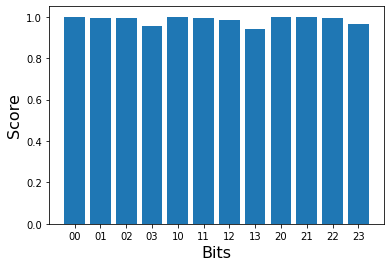

In [ ]:
Ylf=Rc3
Xlf=['00','01','02','03','10','11','12','13','20','21','22','23']
plt.bar(Xlf,Ylf)
plt.xlabel("Bits", fontsize=16)  
plt.ylabel("Score", fontsize=16)

En jouant sur les hyperparamètres, on arrive finalement à bien récupérer tous les bits forts. Le schéma est donc vulnérable. Eve peut récupérer les messages secrets.

# Modélisation 3: Une vérification
Un élément que l'on n'a pas anticipé mais qui pourrait s'avérer important et pourrait avoir entrainer une surestimation des scores précèdents : on a pris les mêmes images dans 'Base' et 'Couverture' (ce qui manque aussi peut-être un peu de réalisme dans une situation d'échange de messages secrets). On prend cette fois des images de base et de couverture génerées indépendemment. On teste sur un bit fort et un bit faible. On retrouve alors les mêmes résultats. Notre premier choix ne posait donc pas de problème.

!////DEBUT ZONE CREATION FICHIER COUVERTURE2////!

In [ ]:
##Créer un dossier Couverture2 dans /content (sous Colab, direction à changer si executer ailleurs)##
path2 = "/content/Couverture2"
os.mkdir(path2)

In [ ]:
##Génère une base d'image (libre de droit) et les stock dans le fichier Couverture2##
for i in range(10):
  fullfilename = os.path.join(path2, "photo" + str(i) + ".jpg")
  urllib.request.urlretrieve("https://picsum.photos/10/10", fullfilename)

!////FIN ZONE CREATION FICHIER COUVERTURE2////!

Dans la cellule qui suit, on pourra adapter à son environnement d'éxecution le chemin d'accès path2 au fichier 'Couverture2' ("/content/Couverture2").

In [ ]:
##Créer un dataframe avec ce qui précède##
K2=[]
for files1 in os.listdir(path):
  for files2 in os.listdir(path2):
    if files1!='.ipynb_checkpoints' and files2!='.ipynb_checkpoints':
      u1=path+'/'+files1
      u2=path2+'/'+files2
      image1=mpimg.imread(u1)
      image2=mpimg.imread(u2)
      arrayB=np.array(image2)
      arrayC=np.array(image1)
      arrayD=np.array(Dissimulation(np.array(image1),np.array(image2)))
      arrayR=Recuperation(arrayD)
      K2.append([arrayB,arrayC,arrayD,arrayR])
dfC = pandas.DataFrame(K2, columns = ['Base', 'Couverture', 'Dissimulation', 'Récupération'])

In [ ]:
dfC

,Base,Couverture,Dissimulation,Récupération
0,"[[[252, 229, 188], [251, 229, 190], [252, 230,...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[223, 238, 235], [223, 238, 235], [223, 238,...","[[[240, 224, 176], [240, 224, 176], [240, 224,..."
1,"[[[103, 102, 54], [146, 145, 97], [166, 166, 1...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[214, 230, 227], [217, 233, 230], [218, 234,...","[[[96, 96, 48], [144, 144, 96], [160, 160, 112..."
2,"[[[56, 72, 124], [63, 79, 131], [74, 90, 142],...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[211, 228, 231], [211, 228, 232], [212, 229,...","[[[48, 64, 112], [48, 64, 128], [64, 80, 128],..."
3,"[[[129, 119, 109], [194, 181, 172], [223, 210,...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[216, 231, 230], [220, 235, 234], [221, 237,...","[[[128, 112, 96], [192, 176, 160], [208, 208, ..."
4,"[[[123, 128, 124], [160, 166, 162], [166, 172,...","[[[218, 226, 229], [220, 228, 231], [222, 230,...","[[[215, 232, 231], [218, 234, 234], [218, 234,...","[[[112, 128, 112], [160, 160, 160], [160, 160,..."
...,...,...,...,...
95,"[[[151, 131, 124], [191, 173, 169], [142, 132,...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[169, 88, 55], [155, 90, 42], [168, 104, 56]...","[[[144, 128, 112], [176, 160, 160], [128, 128,..."
96,"[[[242, 245, 234], [254, 255, 246], [182, 185,...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[175, 95, 62], [159, 95, 47], [171, 107, 59]...","[[[240, 240, 224], [240, 240, 240], [176, 176,..."
97,"[[[37, 46, 55], [38, 47, 56], [37, 45, 56], [3...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[162, 82, 51], [146, 82, 35], [162, 98, 51],...","[[[32, 32, 48], [32, 32, 48], [32, 32, 48], [3..."
98,"[[[48, 72, 146], [37, 61, 131], [45, 73, 138],...","[[[164, 89, 50], [158, 84, 47], [165, 96, 63],...","[[[163, 84, 57], [146, 83, 40], [162, 100, 56]...","[[[48, 64, 144], [32, 48, 128], [32, 64, 128],..."


In [ ]:
dfC2=Decoupepixel(dfC)

In [ ]:
dfC2

,bit27,bit26,bit25,bit24,bit23,bit22,bit21,bit20,bit17,bit16,bit15,bit14,bit13,bit12,bit11,bit10,bit07,bit06,bit05,bit04,bit03,bit02,bit01,bit00,Pixel Dissimulation
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
9996,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
9997,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
9998,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [ ]:
dfC2 = dfC2.sample(frac = 1) 
dfC2_train = dfC2.head(5000)
dfC2_test = dfC2.tail(5000)

In [ ]:
##Classifier sur le deuxième bit des rouges##
lfC00 = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
lfC00.fit(dfC2_train['Pixel Dissimulation'].values.tolist(),dfC2_train['bit01'])

Iteration 1, loss = 0.67562144
Iteration 2, loss = 0.66048920
Iteration 3, loss = 0.64357275
Iteration 4, loss = 0.62562923
Iteration 5, loss = 0.60606685
Iteration 6, loss = 0.58416554
Iteration 7, loss = 0.55930515
Iteration 8, loss = 0.53081451
Iteration 9, loss = 0.49839116
Iteration 10, loss = 0.46202775
Iteration 11, loss = 0.42226980
Iteration 12, loss = 0.38003368
Iteration 13, loss = 0.33696433
Iteration 14, loss = 0.29500209
Iteration 15, loss = 0.25572543
Iteration 16, loss = 0.22015681
Iteration 17, loss = 0.18880697
Iteration 18, loss = 0.16168399
Iteration 19, loss = 0.13848533
Iteration 20, loss = 0.11875564
Iteration 21, loss = 0.10201682
Iteration 22, loss = 0.08797291
Iteration 23, loss = 0.07613256
Iteration 24, loss = 0.06610688
Iteration 25, loss = 0.05776267
Iteration 26, loss = 0.05070111
Iteration 27, loss = 0.04481916
Iteration 28, loss = 0.03981734
Iteration 29, loss = 0.03555030
Iteration 30, loss = 0.03196884
Iteration 31, loss = 0.02887260
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=21, shuffle=True, solver='sgd',
              tol=1e-09, validation_fraction=0.1, verbose=10, warm_start=False)

In [ ]:
lfC00.score(dfC2_test['Pixel Dissimulation'].values.tolist(),dfC2_test['bit00'])

1.0

In [ ]:
##Classifier sur le huitième bit des rouges##
lfC07 = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
lfC07.fit(dfC2_train['Pixel Dissimulation'].values.tolist(),dfC2_train['bit07'])

Iteration 1, loss = 0.69702734
Iteration 2, loss = 0.69488793
Iteration 3, loss = 0.69381233
Iteration 4, loss = 0.69320378
Iteration 5, loss = 0.69265274
Iteration 6, loss = 0.69222722
Iteration 7, loss = 0.69172259
Iteration 8, loss = 0.69129631
Iteration 9, loss = 0.69086708
Iteration 10, loss = 0.69040381
Iteration 11, loss = 0.69003395
Iteration 12, loss = 0.68962512
Iteration 13, loss = 0.68924752
Iteration 14, loss = 0.68892323
Iteration 15, loss = 0.68855163
Iteration 16, loss = 0.68826398
Iteration 17, loss = 0.68790909
Iteration 18, loss = 0.68761716
Iteration 19, loss = 0.68733352
Iteration 20, loss = 0.68703443
Iteration 21, loss = 0.68676405
Iteration 22, loss = 0.68649389
Iteration 23, loss = 0.68623737
Iteration 24, loss = 0.68599594
Iteration 25, loss = 0.68573704
Iteration 26, loss = 0.68549140
Iteration 27, loss = 0.68526331
Iteration 28, loss = 0.68511133
Iteration 29, loss = 0.68482330
Iteration 30, loss = 0.68463963
Iteration 31, loss = 0.68442701
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=21, shuffle=True, solver='sgd',
              tol=1e-09, validation_fraction=0.1, verbose=10, warm_start=False)

In [ ]:
lfC07.score(dfC2_test['Pixel Dissimulation'].values.tolist(),dfC2_test['bit07'])

0.5876

# Conclusion
On a donc testé et constaté que les modèles type "LSB" permettaient d'échanger de l'information de manière insoupçonnable(peu de déformation de la couverture) et sans trop de distortion de l'information secrète (peu de déformation de la base). On s'est intéressé à la sécurité de ce schéma suite à une fuite d'information. On a montré (dans le cas avec ou sans permutation) que ce schéma était vulnérable face à des attaques utilisant des outils simples de deep learning. Néanmoins, on s'est placé ici dans le cas où les images sont de petite dimension. Dans le cas d'images plus grandes, il est possible que la question de la capacité de calcul pour obtenir des prédictions de la même qualité que celles que l'on a obtenues peut se poser. Pouvant rendre alors le schéma plus robuste face à ce genre d'attaque. D'autres contre-mesures peuvent aussi être envisagées (appliquer une fonction inversible sur les bits forts de l'image de base avant dissimulation, permutation sur les intensités RGB, ...) qui pourraient aussi rendre le schéma plus robuste.